## Ìå®ÌÇ§ÏßÄ ÏÑ§Ïπò Î∞è Î∂àÎü¨Ïò§Í∏∞

In [ ]:

# 1. ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏

%pip install yfinance  # (Colab Îì±ÏóêÏÑú ÌïÑÏöî Ïãú)
%pip install tensorflow
%pip install matplot
%pip install seaborn
%pip install ta
import yfinance as yf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import random



## Î™®Îç∏ Íµ¨Ï∂ï

1. Îã®Ïàú Î∂ÑÌï†(80/20) | SentimentÍ∞í 0ÏúºÎ°ú Í≥†Ï†ï


In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

# RMSE Í≥ÑÏÇ∞ Ìï®Ïàò Ï†ïÏùò
def calculate_rmse(Y_true, Y_pred):
    return np.sqrt(mean_squared_error(Y_true, Y_pred))

# MAE Í≥ÑÏÇ∞ Ìï®Ïàò Ï†ïÏùò (sklearn ÏÇ¨Ïö©)
def calculate_mae(Y_true, Y_pred):
    return mean_absolute_error(Y_true, Y_pred)

# MAPE Í≥ÑÏÇ∞ Ìï®Ïàò Ï†ïÏùò
def calculate_mape(Y_true, Y_pred):
    y_true = np.array(Y_true)
    y_pred = np.array(Y_pred)
    # Ïã§Ï†úÍ∞íÏù¥ 0Ïù¥Î©¥ ÏûëÏùÄ Í∞íÏúºÎ°ú ÎåÄÏ≤¥ÌïòÏó¨ Í≥ÑÏÇ∞
    y_true_adj = np.where(y_true == 0, 0.001, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100

# Í≤∞Í≥º Ï†ÄÏû•ÏùÑ ÏúÑÌïú Îπà ÎîïÏÖîÎÑàÎ¶¨ Ï¥àÍ∏∞Ìôî
results = {
    'Company': [],
    'RMSE (no sentiment)': [],
    'RMSE (with sentiment)': [],
}

# Í∏∞Ï°¥ Í≤∞Í≥º ÌååÏùºÏù¥ ÏûàÎäîÏßÄ ÌôïÏù∏ÌïòÍ≥†, ÏûàÎã§Î©¥ Î∂àÎü¨Ïò§Í∏∞
results_file_path = "/content/drive/MyDrive/LSTM_results.csv"
if os.path.isfile(results_file_path):
    existing_results = pd.read_csv(results_file_path)
else:
    existing_results = None

# (ÏòàÏãú) Ïó¨Îü¨ Ï¢ÖÎ™©Ïóê ÎåÄÌïú TickerÎ•º Îã¥ÏùÄ ÎîïÏÖîÎÑàÎ¶¨
stock_dict = {
    "Apple": "AAPL",
    "Microsoft": "MSFT"
}

# ÏòàÏãú: 2020-01-01 ~ 2023-01-01 Íµ¨Í∞Ñ
start_date = "2024-01-01"
end_date   = "2025-01-01"

#----------------------------------------------
# LSTM ÏúàÎèÑÏö∞ Íµ¨ÏÑ± Ìï®Ïàò
#----------------------------------------------
def create_dataset(dataset, seq_size):
    X, Y = [], []
    for i in range(len(dataset) - seq_size - 1):
        X.append(dataset[i:(i + seq_size)])
        Y.append(dataset[i + seq_size])
    return np.array(X), np.array(Y)

#----------------------------------------------
# Í∞Å Ï¢ÖÎ™©Î≥ÑÎ°ú ÌïôÏäµ/ÏòàÏ∏° ÏàòÌñâ
#----------------------------------------------
for company_name, company_code in stock_dict.items():
    #==============================================
    # 1) "No Sentiment": ÏïºÌõÑ ÌååÏù¥ÎÇ∏Ïä§ Îç∞Ïù¥ÌÑ∞Îßå
    #==============================================
    df_no_sentiment = yf.download(company_code, start=start_date, end=end_date, progress=False)
    df_no_sentiment.reset_index(inplace=True)
    df_no_sentiment = df_no_sentiment[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df_no_sentiment.fillna(method='ffill', inplace=True)

    #==============================================
    # 2) "With Sentiment": 0ÏúºÎ°ú Í≥†Ï†ïÎêú Ïª¨Îüº Ï∂îÍ∞Ä
    #==============================================
    df_with_sentiment = df_no_sentiment.copy()
    df_with_sentiment["Sentiment"] = 0.0

    # Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
    rmse_results_no_sentiment = []
    rmse_results_with_sentiment = []

    seq_size = 10  # ÏãúÌÄÄÏä§ Í∏∏Ïù¥

    #----------------------------------------------------------------
    # (A) No Sentiment ÏºÄÏù¥Ïä§
    #----------------------------------------------------------------
    # date Ï†úÏô∏ -> ['Open','High','Low','Close','Volume']
    columns_no_sentiment = df_no_sentiment.columns[1:]
    data_no_sentiment = df_no_sentiment.iloc[:, 1:].values.astype(float)
    scaler_no_sentiment = MinMaxScaler(feature_range=(0, 1))
    scaled_data_no_sentiment = scaler_no_sentiment.fit_transform(data_no_sentiment)
    X, Y_data = create_dataset(scaled_data_no_sentiment, seq_size)

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    Y_train, Y_test = Y_data[:train_size], Y_data[train_size:]

    model = Sequential()
    model.add(LSTM(50, return_sequences=True,
                   input_shape=(seq_size, len(columns_no_sentiment)),
                   kernel_regularizer=l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, kernel_regularizer=l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(len(columns_no_sentiment)))
    model.compile(optimizer='adam', loss='mean_squared_error')

    def scheduler(epoch, lr):
        return lr * 0.99
    callback = LearningRateScheduler(scheduler)

    model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
              epochs=50, batch_size=32, callbacks=[callback], verbose=1)

    predictions = model.predict(X_test)
    rmse_no_sent = calculate_rmse(Y_test, predictions)
    mae_no_sent = calculate_mae(Y_test, predictions)
    mape_no_sent = calculate_mape(Y_test, predictions)
    rmse_results_no_sentiment.append(rmse_no_sent)

    print(f"\n{company_name} (No Sentiment) Metrics:")
    print("  RMSE: {:.4f}".format(rmse_no_sent))
    print("  MAE: {:.4f}".format(mae_no_sent))
    print("  MAPE: {:.2f}%".format(mape_no_sent))
    # Í∞úÎ≥Ñ ÏÉòÌîå Ïò§Ï∞® ÌôïÏù∏ (Ï≤´ 5Í∞ú ÏÉòÌîå)
    for i in range(5):
        error = Y_test[i] - predictions[i]
        print(f"  Sample {i+1} - Actual: {Y_test[i]}, Predicted: {predictions[i]}, Error: {error}")
    # ¬±5% Ïò§Ï∞® ÎÇ¥ Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
    threshold = 0.05
    relative_errors = np.abs((Y_test - predictions) / np.where(Y_test==0, 0.001, Y_test))
    accurate_ratio = np.mean(relative_errors < threshold)
    print("  Accuracy (within ¬±5% error): {:.2f}%".format(accurate_ratio * 100))

    #----------------------------------------------------------------
    # (B) With Sentiment ÏºÄÏù¥Ïä§ (Sentiment=0)
    #----------------------------------------------------------------
    # date Ï†úÏô∏ -> ['Open','High','Low','Close','Volume','Sentiment']
    columns_with_sentiment = df_with_sentiment.columns[1:]
    data_with_sentiment = df_with_sentiment.iloc[:, 1:].values.astype(float)
    scaler_with_sentiment = MinMaxScaler(feature_range=(0, 1))
    scaled_data_with_sentiment = scaler_with_sentiment.fit_transform(data_with_sentiment)
    X_s, Y_data_s = create_dataset(scaled_data_with_sentiment, seq_size)

    train_size_s = int(len(X_s) * 0.8)
    X_train_s, X_test_s = X_s[:train_size_s], X_s[train_size_s:]
    Y_train_s, Y_test_s = Y_data_s[:train_size_s], Y_data_s[train_size_s:]

    model_s = Sequential()
    model_s.add(LSTM(50, return_sequences=True,
                     input_shape=(seq_size, len(columns_with_sentiment)),
                     kernel_regularizer=l2(1e-5)))
    model_s.add(Dropout(0.2))
    model_s.add(LSTM(50, kernel_regularizer=l2(1e-5)))
    model_s.add(Dropout(0.2))
    model_s.add(Dense(len(columns_with_sentiment)))
    model_s.compile(optimizer='adam', loss='mean_squared_error')

    model_s.fit(X_train_s, Y_train_s, validation_data=(X_test_s, Y_test_s),
                epochs=50, batch_size=32, callbacks=[callback], verbose=1)

    predictions_s = model_s.predict(X_test_s)
    rmse_with_sent = calculate_rmse(Y_test_s, predictions_s)
    mae_with_sent = calculate_mae(Y_test_s, predictions_s)
    mape_with_sent = calculate_mape(Y_test_s, predictions_s)
    rmse_results_with_sentiment.append(rmse_with_sent)

    print(f"\n{company_name} (With Sentiment=0) Metrics:")
    print("  RMSE: {:.4f}".format(rmse_with_sent))
    print("  MAE: {:.4f}".format(mae_with_sent))
    print("  MAPE: {:.2f}%".format(mape_with_sent))
    # Í∞úÎ≥Ñ ÏÉòÌîå Ïò§Ï∞® ÌôïÏù∏ (Ï≤´ 5Í∞ú ÏÉòÌîå)
    for i in range(5):
        error = Y_test_s[i] - predictions_s[i]
        print(f"  Sample {i+1} - Actual: {Y_test_s[i]}, Predicted: {predictions_s[i]}, Error: {error}")
    # ¬±5% Ïò§Ï∞® ÎÇ¥ Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
    relative_errors_s = np.abs((Y_test_s - predictions_s) / np.where(Y_test_s==0, 0.001, Y_test_s))
    accurate_ratio_s = np.mean(relative_errors_s < threshold)
    print("  Accuracy (within ¬±5% error): {:.2f}%".format(accurate_ratio_s * 100))

    #----------------------------------------------------------------
    # Í≤∞Í≥º Ï∂úÎ†• Î∞è Ï†ÄÏû•
    #----------------------------------------------------------------
    print(f"\n{company_name} (No Sentiment) RMSE: {rmse_results_no_sentiment}")
    print(f"{company_name} (With Sentiment=0) RMSE: {rmse_results_with_sentiment}")

    results['Company'].append(company_code)
    results['RMSE (no sentiment)'].append(rmse_results_no_sentiment)
    results['RMSE (with sentiment)'].append(rmse_results_with_sentiment)

df_results = pd.DataFrame(results)
print("\nFinal Results:")
print(df_results)

Epoch 1/50


/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/544065624.py:74: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_no_sentiment.fillna(method='ffill', inplace=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 53ms/step - loss: 0.1501 - val_loss: 0.2399 - learning_rate: 9.9000e-04
Epoch 2/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 0.0731 - val_loss: 0.0532 - learning_rate: 9.8010e-04
Epoch 3/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 17ms/step - loss: 0.0252 - val_loss: 0.0096 - learning_rate: 9.7030e-04
Epoch 4/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 0.0189 - val_loss: 0.0223 - learning_rate: 9.6060e-04
Epoch 5/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 0.0161 - val_loss: 0.0165 - learning_rate: 9.5099e-04
Epoch 6/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 0.0142 - val_loss: 0.0128 - learning_rate: 9.4148e-04
Epoch 7/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 0.0148 -

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 50ms/step - loss: 0.1091 - val_loss: 0.1232 - learning_rate: 9.9000e-04
Epoch 2/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 0.0316 - val_loss: 0.0085 - learning_rate: 9.8010e-04
Epoch 3/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step - loss: 0.0226 - val_loss: 0.0096 - learning_rate: 9.7030e-04
Epoch 4/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 0.0154 - val_loss: 0.0330 - learning_rate: 9.6060e-04
Epoch 5/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 0.0179 - val_loss: 0.0242 - learning_rate: 9.5099e-04
Epoch 6/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 0.0114 - val_loss: 0.0081 - learning_rate: 9.4148e-04
Epoch 7/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 0.0107 -

/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/544065624.py:74: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_no_sentiment.fillna(method='ffill', inplace=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 52ms/step - loss: 0.1990 - val_loss: 0.1086 - learning_rate: 9.9000e-04
Epoch 2/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 0.0603 - val_loss: 0.0230 - learning_rate: 9.8010e-04
Epoch 3/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 0.0326 - val_loss: 0.0173 - learning_rate: 9.7030e-04
Epoch 4/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 12ms/step - loss: 0.0275 - val_loss: 0.0257 - learning_rate: 9.6060e-04
Epoch 5/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 0.0242 - val_loss: 0.0211 - learning_rate: 9.5099e-04
Epoch 6/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 11ms/step - loss: 0.0225 - val_loss: 0.0163 - learning_rate: 9.4148e-04
Epoch 7/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 11ms/step - loss: 0.0212 -

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 49ms/step - loss: 0.1806 - val_loss: 0.1116 - learning_rate: 9.9000e-04
Epoch 2/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 0.0625 - val_loss: 0.0178 - learning_rate: 9.8010e-04
Epoch 3/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 0.0308 - val_loss: 0.0168 - learning_rate: 9.7030e-04
Epoch 4/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 0.0269 - val_loss: 0.0214 - learning_rate: 9.6060e-04
Epoch 5/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 0.0231 - val_loss: 0.0189 - learning_rate: 9.5099e-04
Epoch 6/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 0.0192 - val_loss: 0.0146 - learning_rate: 9.4148e-04
Epoch 7/50
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 0.0196 - val_

## Rolling Window | LSTM(50) ‚Üí Dropout ‚Üí LSTM(50) ‚Üí Dropout ‚Üí Dense(len(columns))

In [ ]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --------------------------------------------
# ÏßÄÌëú Í≥ÑÏÇ∞ Ìï®Ïàò
# --------------------------------------------
def calculate_rmse(Y_true, Y_pred):
    return np.sqrt(mean_squared_error(Y_true, Y_pred))

def calculate_mae(Y_true, Y_pred):
    return mean_absolute_error(Y_true, Y_pred)

def calculate_mape(Y_true, Y_pred):
    y_true = np.array(Y_true)
    y_pred = np.array(Y_pred)
    y_true_adj = np.where(y_true == 0, 0.001, y_true)  # 0ÏúºÎ°ú ÎÇòÎàÑÎäî Í≤É Î∞©ÏßÄ
    return np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100

# --------------------------------------------
# ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞ Íµ¨ÏÑ± (Ï¢ÖÍ∞ÄÎßå ÏòàÏ∏°)
# --------------------------------------------
def create_dataset(dataset, seq_size, target_index):
    X, Y = [], []
    for i in range(len(dataset) - seq_size - 1):
        X.append(dataset[i:(i + seq_size)])
        Y.append(dataset[i + seq_size, target_index])  # Ï¢ÖÍ∞ÄÎßå ÏòàÏ∏°
    return np.array(X), np.array(Y)

# --------------------------------------------
# Î°§ÎßÅ ÏúàÎèÑÏö∞ LSTM ÌïôÏäµ/ÏòàÏ∏°
# --------------------------------------------
def rolling_window_evaluation(X, Y, seq_size, input_dim,
                              epochs=50, batch_size=32,
                              train_window=500, test_window=100):
    total_samples = len(X)
    metrics_list = []

    for start in range(0, total_samples - train_window - test_window + 1, test_window):
        X_train = X[start: start + train_window]
        Y_train = Y[start: start + train_window]
        X_test = X[start + train_window: start + train_window + test_window]
        Y_test = Y[start + train_window: start + train_window + test_window]

        model = Sequential()
        model.add(LSTM(50, return_sequences=True,
                       input_shape=(seq_size, input_dim),
                       kernel_regularizer=l2(1e-5)))
        model.add(Dropout(0.2))
        model.add(LSTM(50, kernel_regularizer=l2(1e-5)))
        model.add(Dropout(0.2))
        model.add(Dense(1))  # Ï¢ÖÍ∞Ä ÌïòÎÇòÎßå ÏòàÏ∏°
        model.compile(optimizer='adam', loss='mean_squared_error')

        def scheduler(epoch, lr):
            return lr * 0.99
        callback = LearningRateScheduler(scheduler)

        model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=epochs, batch_size=batch_size, callbacks=[callback], verbose=0)

        predictions = model.predict(X_test)
        rmse = calculate_rmse(Y_test, predictions)
        mae = calculate_mae(Y_test, predictions)
        mape = calculate_mape(Y_test, predictions)

        metrics_list.append((rmse, mae, mape))

    return metrics_list

# --------------------------------------------
# ÏÑ§Ï†ï
# --------------------------------------------
results = {
    'Company': [],
    'RMSE (no sentiment)': [],
    'RMSE (with sentiment)': [],
}

results_file_path = "LSTM_results.csv"
stock_dict = {
    "Apple": "AAPL",
    "Microsoft": "MSFT"
}
start_date = "2020-01-01"
end_date   = "2025-01-01"
seq_size = 10
target_index = 3  # 'Close' Ïª¨Îüº ÏúÑÏπò

# --------------------------------------------
# Ï¢ÖÎ™©Î≥Ñ ÌïôÏäµ Î£®ÌîÑ
# --------------------------------------------
for company_name, company_code in stock_dict.items():
    print(f"\nüìà Processing {company_name} ({company_code})...")

    # 1) ÏïºÌõÑ ÌååÏù¥ÎÇ∏Ïä§ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
    df = yf.download(company_code, start=start_date, end=end_date, progress=False)
    df.reset_index(inplace=True)
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df.ffill(inplace=True)

    # 2) Í∞êÏÑ± Î∂ÑÏÑù ÏóÜÎäî ÏºÄÏù¥Ïä§
    df_no_sentiment = df.copy()
    cols_no = df_no_sentiment.columns[1:]
    data_no = df_no_sentiment[cols_no].values.astype(float)
    scaler_no = MinMaxScaler()
    scaled_no = scaler_no.fit_transform(data_no)
    X_no, Y_no = create_dataset(scaled_no, seq_size, target_index)

    metrics_no = rolling_window_evaluation(X_no, Y_no, seq_size, len(cols_no),
                                           epochs=50, batch_size=32,
                                           train_window=500, test_window=100)

    avg_rmse_no = np.mean([m[0] for m in metrics_no])
    avg_mae_no  = np.mean([m[1] for m in metrics_no])
    avg_mape_no = np.mean([m[2] for m in metrics_no])

    print(f"{company_name} (No Sentiment) Metrics:")
    print(f"  ‚úÖ RMSE:  {avg_rmse_no:.4f}")
    print(f"  ‚úÖ MAE:   {avg_mae_no:.4f}")
    print(f"  ‚úÖ MAPE:  {avg_mape_no:.2f}%")

    # 3) Í∞êÏÑ± Ï†êÏàò Ìè¨Ìï® (0ÏúºÎ°ú Ï¥àÍ∏∞Ìôî)
    df_with_sentiment = df.copy()
    df_with_sentiment["Sentiment"] = 0.0
    cols_with = df_with_sentiment.columns[1:]
    data_with = df_with_sentiment[cols_with].values.astype(float)
    scaler_with = MinMaxScaler()
    scaled_with = scaler_with.fit_transform(data_with)
    X_with, Y_with = create_dataset(scaled_with, seq_size, target_index)

    metrics_with = rolling_window_evaluation(X_with, Y_with, seq_size, len(cols_with),
                                             epochs=50, batch_size=32,
                                             train_window=500, test_window=100)

    avg_rmse_with = np.mean([m[0] for m in metrics_with])
    avg_mae_with  = np.mean([m[1] for m in metrics_with])
    avg_mape_with = np.mean([m[2] for m in metrics_with])

    print(f"{company_name} (With Sentiment = 0) Metrics:")
    print(f"  ‚úÖ RMSE:  {avg_rmse_with:.4f}")
    print(f"  ‚úÖ MAE:   {avg_mae_with:.4f}")
    print(f"  ‚úÖ MAPE:  {avg_mape_with:.2f}%")

    # Í≤∞Í≥º Ï†ÄÏû•
    results['Company'].append(company_code)
    results['RMSE (no sentiment)'].append(avg_rmse_no)
    results['RMSE (with sentiment)'].append(avg_rmse_with)

# --------------------------------------------
# ÏµúÏ¢Ö Í≤∞Í≥º Ï†ÄÏû•
# --------------------------------------------
df_results = pd.DataFrame(results)
df_results.to_csv(results_file_path, index=False)
print("\nüìä Final Results:")
print(df_results)

## Í∏∞Î≥∏ LSTM + Rolling Window (Ï†ÄÏû•Î∂ÄÎ∂Ñ, ÌèâÍ∞ÄÏßÄÌëú Ï∂îÍ∞Ä) ÏΩîÎìú ÏàòÏ†ï

4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 54ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 63ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 55ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 100ms/step

üìà Apple (AAPL)
[No Sentiment]  RMSE: 0.0472, MAE: 0.0397, MAPE: 14.62%, Accuracy: 23.95%
[With Sentiment] RMSE: 0.0531, MAE: 0.0435, MAPE: 14.51%, Accuracy: 23.46%
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 49ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 46ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 3s/step  
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 42ms/step

üìà Microsoft (MSFT)
[No Sentiment]  RMSE: 0.0409, MAE: 0.0324, MAPE: 7.43%, Accuracy: 41.33%
[With Sentiment] RMSE: 0.0374, MAE: 0.0300, MAPE: 7.27%, Accuracy: 42.75%


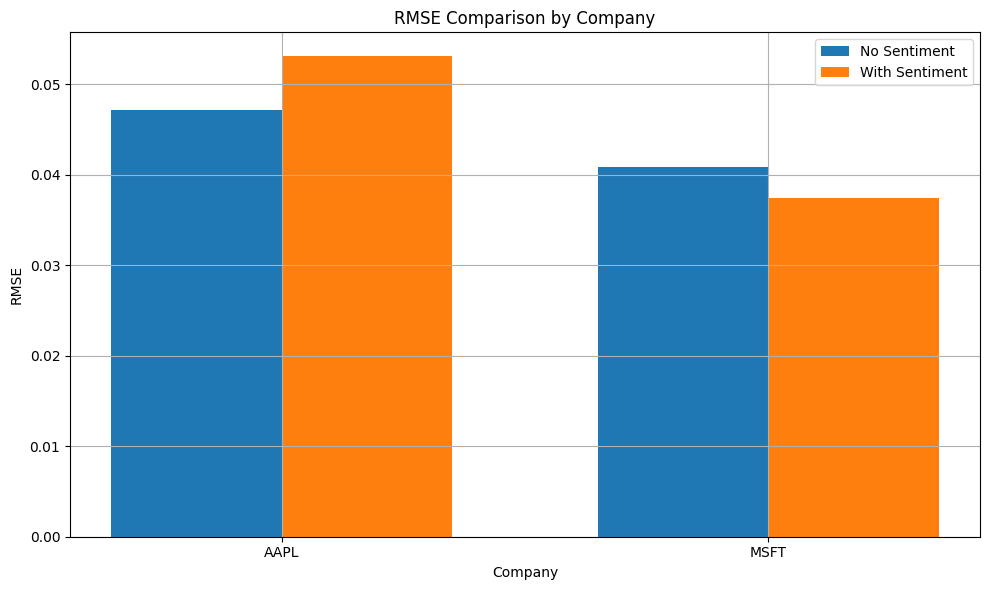

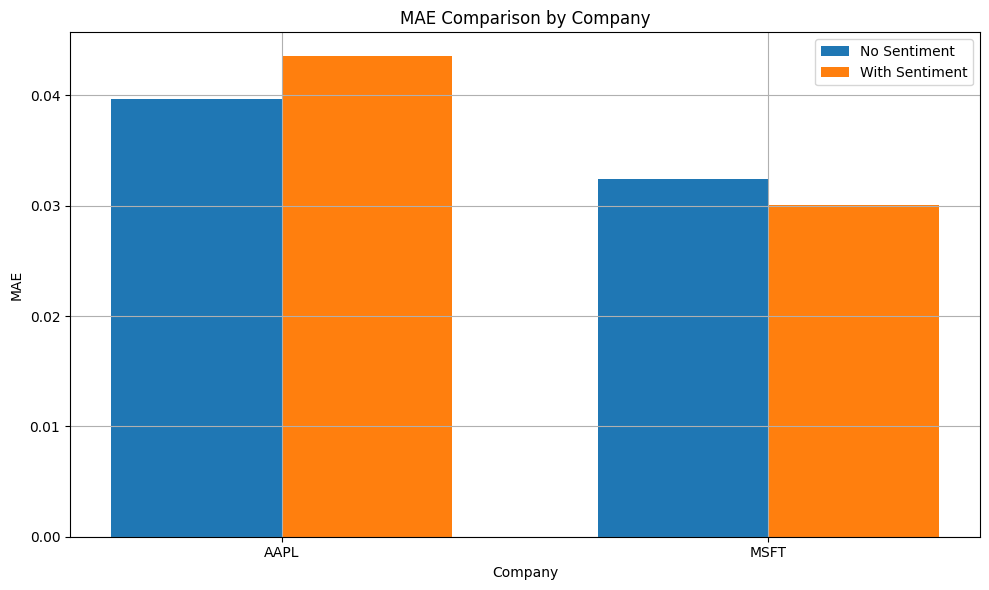

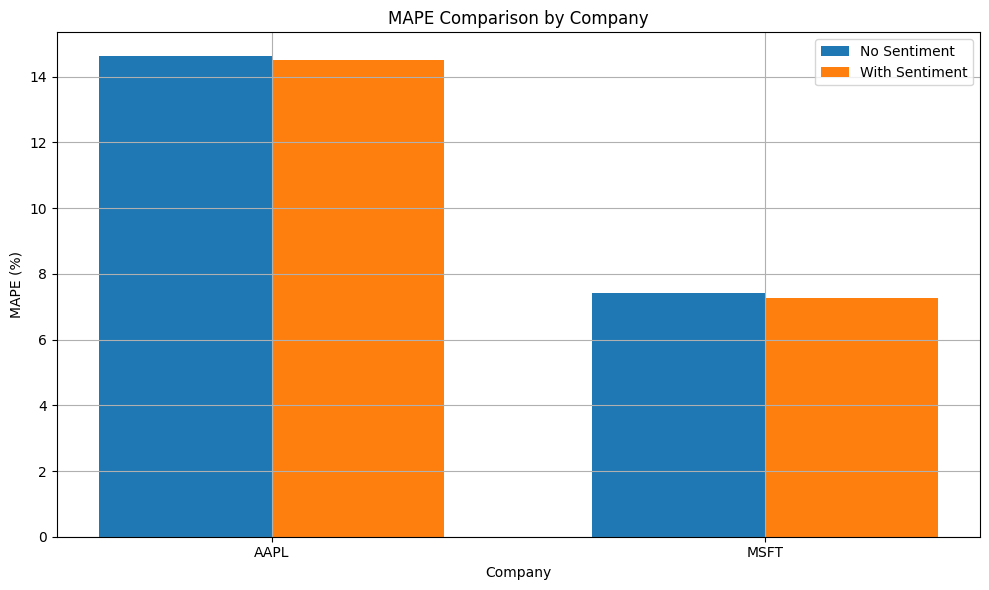

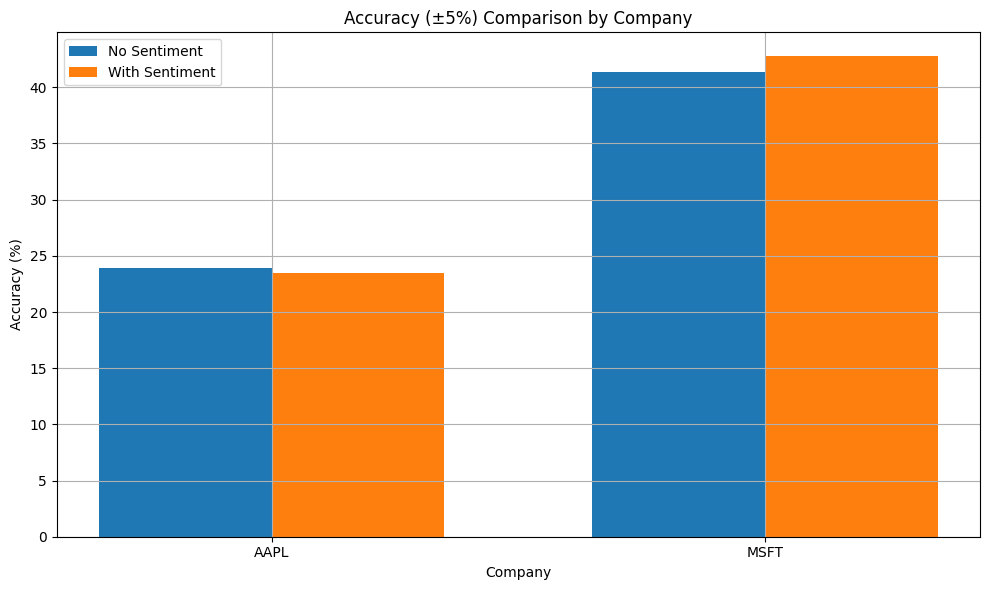

In [8]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ------------------------------
# Ìè¥Îçî ÏÉùÏÑ± Î∞è ÏÑ§Ï†ï
# ------------------------------
os.makedirs("results", exist_ok=True)
results_file_path = "./results/LSTM_results.csv"

# ------------------------------
# ÏßÄÌëú Í≥ÑÏÇ∞ Ìï®Ïàò
# ------------------------------
def calculate_rmse(Y_true, Y_pred):
    return np.sqrt(mean_squared_error(Y_true, Y_pred))

def calculate_mae(Y_true, Y_pred):
    return mean_absolute_error(Y_true, Y_pred)

def calculate_mape(Y_true, Y_pred):
    y_true = np.array(Y_true)
    y_pred = np.array(Y_pred)
    y_true_adj = np.where(y_true == 0, 0.001, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100

# ------------------------------
# Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ± Ìï®Ïàò
# ------------------------------
def create_dataset(dataset, seq_size, target_index):
    X, Y = [], []
    for i in range(len(dataset) - seq_size - 1):
        X.append(dataset[i:(i + seq_size)])
        Y.append(dataset[i + seq_size, target_index])
    return np.array(X), np.array(Y)

# ------------------------------
# Î°§ÎßÅ ÏúàÎèÑÏö∞ ÌèâÍ∞Ä Ìï®Ïàò
# ------------------------------
def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=500, test_window=100, threshold=0.05):
    total_samples = len(X)
    metrics_list = []

    for start in range(0, total_samples - train_window - test_window + 1, test_window):
        X_train = X[start: start + train_window]
        Y_train = Y[start: start + train_window]
        X_test  = X[start + train_window: start + train_window + test_window]
        Y_test  = Y[start + train_window: start + train_window + test_window]

        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')

        def scheduler(epoch, lr):
            return lr * 0.99
        callback = LearningRateScheduler(scheduler)

        model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=epochs, batch_size=batch_size, callbacks=[callback], verbose=0)

        predictions = model.predict(X_test)
        rmse = calculate_rmse(Y_test, predictions)
        mae = calculate_mae(Y_test, predictions)
        mape = calculate_mape(Y_test, predictions)
        relative_errors = np.abs((Y_test - predictions) / np.where(Y_test == 0, 0.001, Y_test))
        accuracy = np.mean(relative_errors < threshold) * 100

        metrics_list.append((rmse, mae, mape, accuracy))

    return metrics_list

# ------------------------------
# ÌïôÏäµ Î∞è ÌèâÍ∞Ä Ïã§Ìñâ
# ------------------------------
results = {
    'Company': [],
    'RMSE (no sentiment)': [],
    'MAE (no sentiment)': [],
    'MAPE (no sentiment)': [],
    'Accuracy (no sentiment)': [],
    'RMSE (with sentiment)': [],
    'MAE (with sentiment)': [],
    'MAPE (with sentiment)': [],
    'Accuracy (with sentiment)': [],
}

stock_dict = {
    "Apple": "AAPL",
    "Microsoft": "MSFT"
}
start_date = "2022-01-01"
end_date = "2025-01-01"
seq_size = 10
target_index = 3

for company_name, ticker in stock_dict.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    df.reset_index(inplace=True)
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df.ffill(inplace=True)

    df_with_sentiment = df.copy()
    df_with_sentiment['Sentiment'] = 0.0

    # No Sentiment
    cols_no = df.columns[1:]
    data_no = df[cols_no].values.astype(float)
    scaler_no = MinMaxScaler()
    scaled_no = scaler_no.fit_transform(data_no)
    X_no, Y_no = create_dataset(scaled_no, seq_size, target_index)

    metrics_no = rolling_window_evaluation(X_no, Y_no, seq_size, cols_no)
    if not metrics_no:
        continue

    avg_rmse_no = np.mean([m[0] for m in metrics_no])
    avg_mae_no = np.mean([m[1] for m in metrics_no])
    avg_mape_no = np.mean([m[2] for m in metrics_no])
    avg_acc_no = np.mean([m[3] for m in metrics_no])

    # With Sentiment
    cols_with = df_with_sentiment.columns[1:]
    data_with = df_with_sentiment[cols_with].values.astype(float)
    scaler_with = MinMaxScaler()
    scaled_with = scaler_with.fit_transform(data_with)
    X_with, Y_with = create_dataset(scaled_with, seq_size, target_index)

    metrics_with = rolling_window_evaluation(X_with, Y_with, seq_size, cols_with)
    if not metrics_with:
        continue

    avg_rmse_with = np.mean([m[0] for m in metrics_with])
    avg_mae_with = np.mean([m[1] for m in metrics_with])
    avg_mape_with = np.mean([m[2] for m in metrics_with])
    avg_acc_with = np.mean([m[3] for m in metrics_with])

    print(f"\nüìà {company_name} ({ticker})")
    print(f"[No Sentiment]  RMSE: {avg_rmse_no:.4f}, MAE: {avg_mae_no:.4f}, MAPE: {avg_mape_no:.2f}%, Accuracy: {avg_acc_no:.2f}%")
    print(f"[With Sentiment] RMSE: {avg_rmse_with:.4f}, MAE: {avg_mae_with:.4f}, MAPE: {avg_mape_with:.2f}%, Accuracy: {avg_acc_with:.2f}%")

    results['Company'].append(ticker)
    results['RMSE (no sentiment)'].append(avg_rmse_no)
    results['MAE (no sentiment)'].append(avg_mae_no)
    results['MAPE (no sentiment)'].append(avg_mape_no)
    results['Accuracy (no sentiment)'].append(avg_acc_no)
    results['RMSE (with sentiment)'].append(avg_rmse_with)
    results['MAE (with sentiment)'].append(avg_mae_with)
    results['MAPE (with sentiment)'].append(avg_mape_with)
    results['Accuracy (with sentiment)'].append(avg_acc_with)

# Í≤∞Í≥º Ï†ÄÏû•
df_results = pd.DataFrame(results)
df_results.to_csv(results_file_path, index=False)

# ------------------------------
# ÏãúÍ∞ÅÌôî Ìï®Ïàò
# ------------------------------
def plot_metric(metric_name, title, ylabel):
    plt.figure(figsize=(10, 6))
    x = df_results['Company']
    no_sentiment = df_results[f'{metric_name} (no sentiment)']
    with_sentiment = df_results[f'{metric_name} (with sentiment)']

    bar_width = 0.35
    index = range(len(x))

    plt.bar(index, no_sentiment, bar_width, label='No Sentiment')
    plt.bar([i + bar_width for i in index], with_sentiment, bar_width, label='With Sentiment')

    plt.xlabel('Company')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks([i + bar_width / 2 for i in index], x)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------
# ÏãúÍ∞ÅÌôî Ïã§Ìñâ
# ------------------------------
plot_metric("RMSE", "RMSE Comparison by Company", "RMSE")
plot_metric("MAE", "MAE Comparison by Company", "MAE")
plot_metric("MAPE", "MAPE Comparison by Company", "MAPE (%)")
plot_metric("Accuracy", "Accuracy (¬±5%) Comparison by Company", "Accuracy (%)")


## ÏΩîÎìú 2 : Í∏∞Î≥∏ LSTM + ÏãúÍ∞ÅÌôî

4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 53ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 50ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 44ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 44ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 49ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 54ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 54ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 46ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 43ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 44ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 42ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 45ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

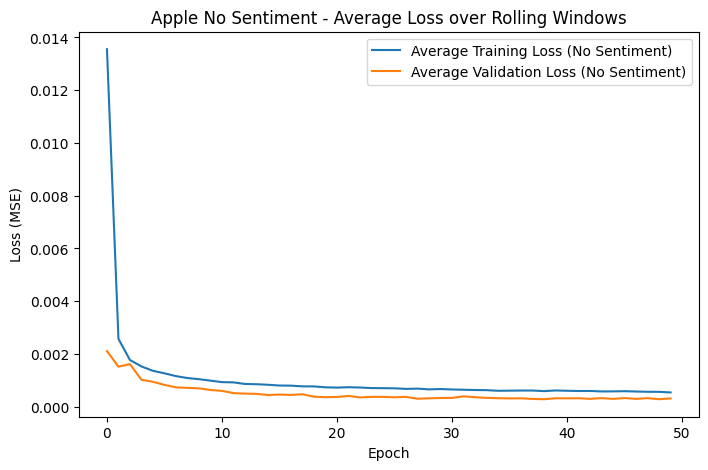

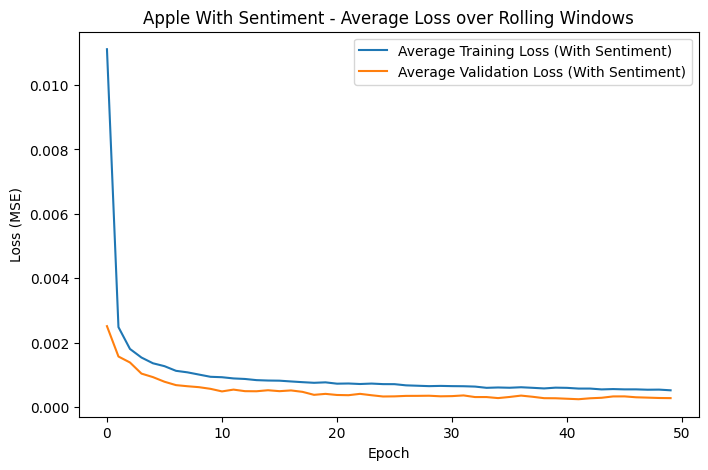

4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 49ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 49ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 53ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 46ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 48ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 48ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 43ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 46ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 47ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 43ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 46ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 50ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

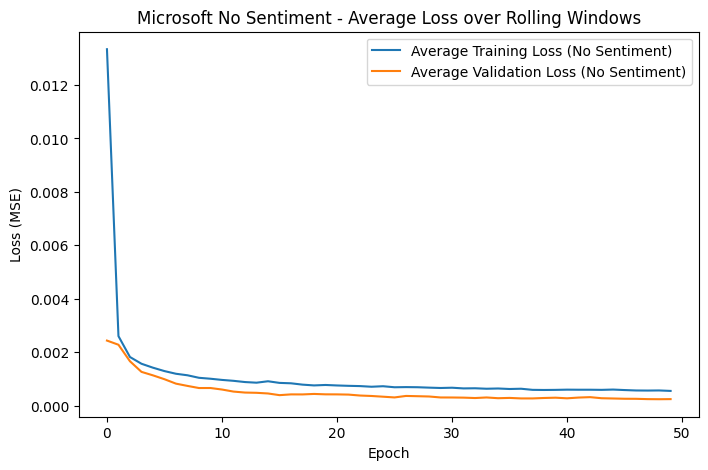

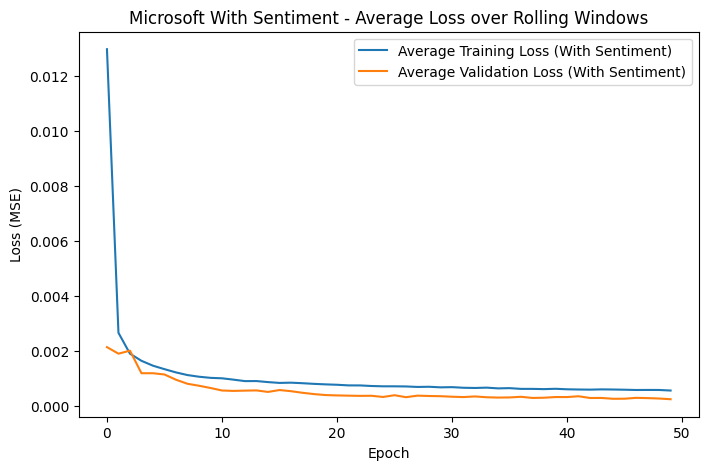


Final Results:
  Company  RMSE (no sentiment)  Accuracy (no sentiment)  \
0    AAPL             0.007627                35.660877   
1    MSFT             0.006841                33.923158   

   RMSE (with sentiment)  Accuracy (with sentiment)  
0               0.007263                  33.922281  
1               0.006642                  33.432807  


In [9]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

# Í≤∞Í≥º Ï†ÄÏû•Ìï† ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ± (ÏóÜÏúºÎ©¥ ÏÉùÏÑ±)
os.makedirs("results", exist_ok=True)

# RMSE, MAE, MAPE Í≥ÑÏÇ∞ Ìï®Ïàò Ï†ïÏùò
def calculate_rmse(Y_true, Y_pred):
    return np.sqrt(mean_squared_error(Y_true, Y_pred))

def calculate_mae(Y_true, Y_pred):
    return mean_absolute_error(Y_true, Y_pred)

def calculate_mape(Y_true, Y_pred):
    y_true = np.array(Y_true)
    y_pred = np.array(Y_pred)
    y_true_adj = np.where(y_true == 0, 0.001, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100

# Í≤∞Í≥º Ï†ÄÏû•ÏùÑ ÏúÑÌïú Îπà ÎîïÏÖîÎÑàÎ¶¨ Ï¥àÍ∏∞Ìôî
results = {
    'Company': [],
    'RMSE (no sentiment)': [],
    'Accuracy (no sentiment)': [],
    'RMSE (with sentiment)': [],
    'Accuracy (with sentiment)': [],
}

results_file_path = "./results/LSTM_results.csv"
if os.path.isfile(results_file_path):
    existing_results = pd.read_csv(results_file_path)
else:
    existing_results = None

# Ïó¨Îü¨ Ï¢ÖÎ™©Ïóê ÎåÄÌïú Ticker
stock_dict = {
    "Apple": "AAPL",
    "Microsoft": "MSFT"
}

# Îç∞Ïù¥ÌÑ∞ Í∏∞Í∞Ñ ÏÑ§Ï†ï
start_date = "2000-01-01"
end_date   = "2025-01-01"

#----------------------------------------------
# LSTM ÏúàÎèÑÏö∞ Íµ¨ÏÑ± Ìï®Ïàò (target_indexÎ•º Ïù¥Ïö©ÌïòÏó¨ Ï¢ÖÍ∞ÄÎßå ÏòàÏ∏°)
#----------------------------------------------
def create_dataset(dataset, seq_size, target_index):
    X, Y = [], []
    for i in range(len(dataset) - seq_size - 1):
        X.append(dataset[i:(i + seq_size)])
        Y.append(dataset[i + seq_size, target_index])
    return np.array(X), np.array(Y)

#----------------------------------------------
# Î°§ÎßÅ ÏúàÎèÑÏö∞ ÌïôÏäµ/Í≤ÄÏ¶ù Ìï®Ïàò (Ï†úÏïàÎêú Î™®Îç∏ Ï†ÅÏö©)
#----------------------------------------------
def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=500, test_window=100, threshold=0.05):
    total_samples = len(X)
    metrics_list = []  # Í∞Å ÏúàÎèÑÏö∞Ïùò (rmse, mae, mape, accuracy)
    history_list = []  # Í∞Å ÏúàÎèÑÏö∞Ïùò history.history (loss, val_loss)
    
    for start in range(0, total_samples - train_window - test_window + 1, test_window):
        X_train = X[start: start + train_window]
        Y_train = Y[start: start + train_window]
        X_test  = X[start + train_window: start + train_window + test_window]
        Y_test  = Y[start + train_window: start + train_window + test_window]
        
        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        def scheduler(epoch, lr):
            return lr * 0.99
        callback = LearningRateScheduler(scheduler)
        
        history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=epochs, batch_size=batch_size, callbacks=[callback], verbose=0)
        
        history_list.append(history.history)
        
        predictions = model.predict(X_test)
        rmse_val = calculate_rmse(Y_test, predictions)
        mae_val  = calculate_mae(Y_test, predictions)
        mape_val = calculate_mape(Y_test, predictions)
        relative_errors = np.abs((Y_test - predictions) / np.where(Y_test==0, 0.001, Y_test))
        accuracy = np.mean(relative_errors < threshold) * 100
        metrics_list.append((rmse_val, mae_val, mape_val, accuracy))
    return metrics_list, history_list

#----------------------------------------------
# Í∞Å Ï¢ÖÎ™©Î≥ÑÎ°ú Rolling Window Î∞©ÏãùÏúºÎ°ú ÌïôÏäµ/ÏòàÏ∏° ÏàòÌñâ (Ï¢ÖÍ∞Ä ÏòàÏ∏°Ïö©)
#----------------------------------------------
# ÏòàÏ∏° ÎåÄÏÉÅ: Ï¢ÖÍ∞Ä ("Close") ‚Üí No SentimentÏóêÏÑúÎäî ['Open','High','Low','Close','Volume']ÏóêÏÑú CloseÎäî Ïù∏Îç±Ïä§ 3  
# With SentimentÏùò Í≤ΩÏö∞ÏóêÎèÑ ÎèôÏùºÌïòÍ≤å, ['Open','High','Low','Close','Volume','Sentiment']ÏóêÏÑú CloseÎäî Ïù∏Îç±Ïä§ 3
target_index = 3

for company_name, company_code in stock_dict.items():
    # 1) "No Sentiment": ÏïºÌõÑ ÌååÏù¥ÎÇ∏Ïä§ Îç∞Ïù¥ÌÑ∞Îßå
    df_no_sentiment = yf.download(company_code, start=start_date, end=end_date, progress=False)
    df_no_sentiment.reset_index(inplace=True)
    df_no_sentiment = df_no_sentiment[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df_no_sentiment.ffill(inplace=True)
    
    # 2) "With Sentiment": 0ÏúºÎ°ú Í≥†Ï†ïÎêú Ïª¨Îüº Ï∂îÍ∞Ä
    df_with_sentiment = df_no_sentiment.copy()
    df_with_sentiment["Sentiment"] = 0.0

    seq_size = 10

    # --- No Sentiment ÏºÄÏù¥Ïä§ ---
    columns_no_sentiment = df_no_sentiment.columns[1:]  # ['Open','High','Low','Close','Volume']
    data_no_sentiment = df_no_sentiment.iloc[:, 1:].values.astype(float)
    scaler_no_sentiment = MinMaxScaler(feature_range=(0, 1))
    scaled_data_no_sentiment = scaler_no_sentiment.fit_transform(data_no_sentiment)
    X_no, Y_no = create_dataset(scaled_data_no_sentiment, seq_size, target_index)
    
    metrics_no, history_no = rolling_window_evaluation(X_no, Y_no, seq_size, columns_no_sentiment,
                                           epochs=50, batch_size=32,
                                           train_window=500, test_window=100, threshold=0.05)
    avg_rmse_no = np.mean([m[0] for m in metrics_no])
    avg_accuracy_no = np.mean([m[3] for m in metrics_no])
    
    print(f"\n{company_name} (No Sentiment) Rolling Window Metrics (Ï¢ÖÍ∞Ä ÏòàÏ∏°):")
    print("  Average RMSE: {:.4f}".format(avg_rmse_no))
    print("  Average Accuracy (¬±5% error): {:.2f}%".format(avg_accuracy_no))
    
    # --- With Sentiment ÏºÄÏù¥Ïä§ ---
    columns_with_sentiment = df_with_sentiment.columns[1:]  # ['Open','High','Low','Close','Volume','Sentiment']
    data_with_sentiment = df_with_sentiment.iloc[:, 1:].values.astype(float)
    scaler_with_sentiment = MinMaxScaler(feature_range=(0, 1))
    scaled_data_with_sentiment = scaler_with_sentiment.fit_transform(data_with_sentiment)
    X_with, Y_with = create_dataset(scaled_data_with_sentiment, seq_size, target_index)
    
    metrics_with, history_with = rolling_window_evaluation(X_with, Y_with, seq_size, columns_with_sentiment,
                                             epochs=50, batch_size=32,
                                             train_window=500, test_window=100, threshold=0.05)
    avg_rmse_with = np.mean([m[0] for m in metrics_with])
    avg_accuracy_with = np.mean([m[3] for m in metrics_with])
    
    print(f"\n{company_name} (With Sentiment=0) Rolling Window Metrics (Ï¢ÖÍ∞Ä ÏòàÏ∏°):")
    print("  Average RMSE: {:.4f}".format(avg_rmse_with))
    print("  Average Accuracy (¬±5% error): {:.2f}%".format(avg_accuracy_with))
    
    results['Company'].append(company_code)
    results['RMSE (no sentiment)'].append(avg_rmse_no)
    results['Accuracy (no sentiment)'].append(avg_accuracy_no)
    results['RMSE (with sentiment)'].append(avg_rmse_with)
    results['Accuracy (with sentiment)'].append(avg_accuracy_with)

    # ----- Ï∂îÍ∞Ä: Í∞Å ÏºÄÏù¥Ïä§Ïùò Î™®Îì† ÏúàÎèÑÏö∞ÏóêÏÑúÏùò Loss Í≥°ÏÑ† ÌèâÍ∑† ÏãúÍ∞ÅÌôî -----
    # ÏòàÎ•º Îì§Ïñ¥, No Sentiment ÏºÄÏù¥Ïä§Ïùò Í≤ΩÏö∞:
    # history_noÎäî Í∞Å ÏúàÎèÑÏö∞Ïùò history dict Î¶¨Ïä§Ìä∏Ïù¥Î©∞, Í∞Å dictÏóê 'loss'ÏôÄ 'val_loss'Í∞Ä ÏûàÏùå.
    # ÎèôÏùºÌïú epoch Ïàò(50)Î•º ÏÇ¨Ïö©ÌïòÎØÄÎ°ú, Í∞Å epochÎ≥Ñ ÌèâÍ∑† lossÎ•º Í≥ÑÏÇ∞Ìï† Ïàò ÏûàÏùå.
    
    # No Sentiment loss ÌèâÍ∑† Í≥ÑÏÇ∞
    train_losses_no = np.array([h['loss'] for h in history_no])
    val_losses_no = np.array([h['val_loss'] for h in history_no])
    avg_train_loss_no = np.mean(train_losses_no, axis=0)
    avg_val_loss_no = np.mean(val_losses_no, axis=0)
    
    plt.figure(figsize=(8, 5))
    plt.plot(avg_train_loss_no, label='Average Training Loss (No Sentiment)')
    plt.plot(avg_val_loss_no, label='Average Validation Loss (No Sentiment)')
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title(f"{company_name} No Sentiment - Average Loss over Rolling Windows")
    plt.legend()
    plt.show()
    
    # With Sentiment loss ÌèâÍ∑† Í≥ÑÏÇ∞
    train_losses_with = np.array([h['loss'] for h in history_with])
    val_losses_with = np.array([h['val_loss'] for h in history_with])
    avg_train_loss_with = np.mean(train_losses_with, axis=0)
    avg_val_loss_with = np.mean(val_losses_with, axis=0)
    
    plt.figure(figsize=(8, 5))
    plt.plot(avg_train_loss_with, label='Average Training Loss (With Sentiment)')
    plt.plot(avg_val_loss_with, label='Average Validation Loss (With Sentiment)')
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title(f"{company_name} With Sentiment - Average Loss over Rolling Windows")
    plt.legend()
    plt.show()

df_results = pd.DataFrame(results)
df_results.to_csv(results_file_path, index=False)
print("\nFinal Results:")
print(df_results)

## ÏΩîÎìú3 : ÏñëÎ∞©Ìñ• LSTM(Bidirectional LSTM)

4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 199ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 196ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 188ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 192ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 177ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 185ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 187ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 177ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 194ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 141ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 162ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 144ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

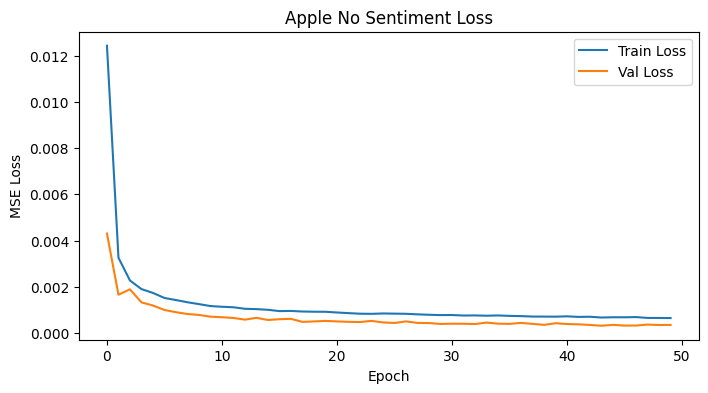

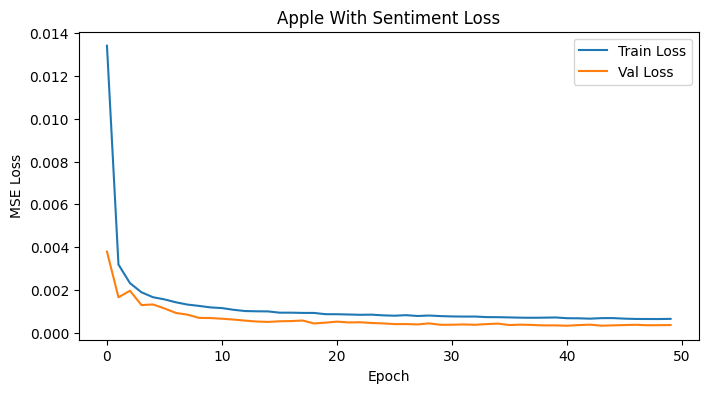

4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 132ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 136ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 131ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 143ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 125ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 124ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 110ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 99ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 138ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 94ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 113ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 106ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

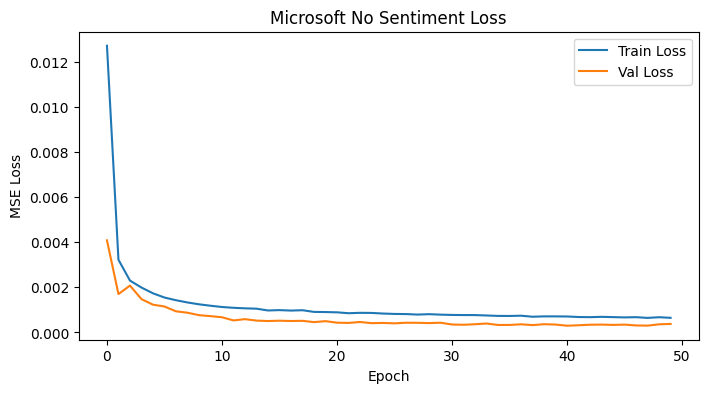

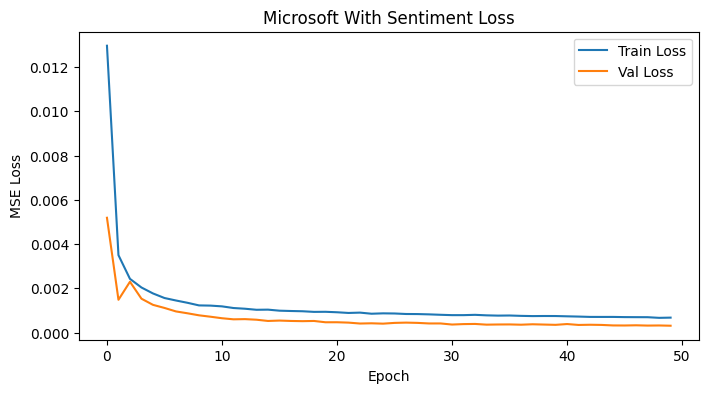


Final Results:
  Company  RMSE (no sentiment)  Accuracy (no sentiment)  \
0    AAPL             0.006889                35.355000   
1    MSFT             0.007408                33.637759   

   RMSE (with sentiment)  Accuracy (with sentiment)  
0               0.007310                  34.205345  
1               0.006569                  34.348793  


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ------------------------------
# Í≤∞Í≥º Ï†ÄÏû• ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
# ------------------------------
os.makedirs("results", exist_ok=True)
results_file_path = "./results/LSTM_results.csv"

# ------------------------------
# ÏßÄÌëú Í≥ÑÏÇ∞ Ìï®Ïàò
# ------------------------------
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true_adj = np.where(y_true == 0, 0.001, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100

# ------------------------------
# ÏãúÍ∞ÅÌôî Ìï®Ïàò
# ------------------------------
def plot_metric(df, metric_name, title, ylabel):
    plt.figure(figsize=(10, 6))
    x = df['Company']
    no_sentiment = df[f'{metric_name} (no sentiment)']
    with_sentiment = df[f'{metric_name} (with sentiment)']

    bar_width = 0.35
    index = range(len(x))

    plt.bar(index, no_sentiment, bar_width, label='No Sentiment')
    plt.bar([i + bar_width for i in index], with_sentiment, bar_width, label='With Sentiment')

    plt.xlabel('Company')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks([i + bar_width / 2 for i in index], x)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------
# ÏãúÌÄÄÏä§ ÏÉùÏÑ± Ìï®Ïàò
# ------------------------------
def create_dataset(data, seq_size, target_idx):
    X, Y = [], []
    for i in range(len(data) - seq_size - 1):
        X.append(data[i:i+seq_size])
        Y.append(data[i+seq_size, target_idx])
    return np.array(X), np.array(Y)

# ------------------------------
# Î°§ÎßÅ ÏúàÎèÑÏö∞ ÌèâÍ∞Ä Ìï®Ïàò
# ------------------------------
def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=500, test_window=100, threshold=0.05):
    metrics, histories = [], []
    for start in range(0, len(X) - train_window - test_window + 1, test_window):
        X_tr, Y_tr = X[start:start+train_window], Y[start:start+train_window]
        X_te, Y_te = X[start+train_window:start+train_window+test_window], Y[start+train_window:start+train_window+test_window]

        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5))),
            Dropout(0.2),
            LSTM(32, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')

        def scheduler(epoch, lr): return lr * 0.99
        lr_cb = LearningRateScheduler(scheduler)

        history = model.fit(X_tr, Y_tr,
                            validation_data=(X_te, Y_te),
                            epochs=epochs, batch_size=batch_size,
                            callbacks=[lr_cb],
                            verbose=0)
        histories.append(history.history)

        preds = model.predict(X_te)
        rmse = calculate_rmse(Y_te, preds)
        mae = calculate_mae(Y_te, preds)
        mape = calculate_mape(Y_te, preds)
        accuracy = np.mean(np.abs((Y_te - preds) / np.where(Y_te==0,1e-3,Y_te)) < threshold) * 100
        metrics.append((rmse, mae, mape, accuracy))
    return metrics, histories

# ------------------------------
# Î©îÏù∏ Ïã§Ìñâ
# ------------------------------
results = {'Company': [], 'RMSE (no sentiment)': [], 'MAE (no sentiment)': [], 'MAPE (no sentiment)': [], 'Accuracy (no sentiment)': [],
           'RMSE (with sentiment)': [], 'MAE (with sentiment)': [], 'MAPE (with sentiment)': [], 'Accuracy (with sentiment)': []}
target_idx = 3  # 'Close'

for name, ticker in {"Apple":"AAPL","Microsoft":"MSFT"}.items():
    df = yf.download(ticker, start="2000-01-01", end="2025-03-01", progress=False)
    df.reset_index(inplace=True)
    df = df[['Date','Open','High','Low','Close','Volume']].ffill()

    # No sentiment
    data_no = df.iloc[:,1:].values.astype(float)
    scaled_no = MinMaxScaler().fit_transform(data_no)
    X_no, Y_no = create_dataset(scaled_no, seq_size=10, target_idx=target_idx)
    metrics_no, hist_no = rolling_window_evaluation(X_no, Y_no, seq_size=10, columns=df.columns[1:])
    rmse_no = np.mean([m[0] for m in metrics_no])
    mae_no = np.mean([m[1] for m in metrics_no])
    mape_no = np.mean([m[2] for m in metrics_no])
    acc_no = np.mean([m[3] for m in metrics_no])

    # With sentiment (0)
    df_with = df.copy(); df_with['Sentiment'] = 0.0
    data_with = df_with.iloc[:,1:].values.astype(float)
    scaled_with = MinMaxScaler().fit_transform(data_with)
    X_with, Y_with = create_dataset(scaled_with, seq_size=10, target_idx=target_idx)
    metrics_with, hist_with = rolling_window_evaluation(X_with, Y_with, seq_size=10, columns=df_with.columns[1:])
    rmse_with = np.mean([m[0] for m in metrics_with])
    mae_with = np.mean([m[1] for m in metrics_with])
    mape_with = np.mean([m[2] for m in metrics_with])
    acc_with = np.mean([m[3] for m in metrics_with])

    print(f"{name}: NoSent RMSE={rmse_no:.4f}, MAE={mae_no:.4f}, MAPE={mape_no:.2f}%, Acc={acc_no:.2f}% | WithSent RMSE={rmse_with:.4f}, MAE={mae_with:.4f}, MAPE={mape_with:.2f}%, Acc={acc_with:.2f}%")

    results['Company'].append(ticker)
    results['RMSE (no sentiment)'].append(rmse_no)
    results['MAE (no sentiment)'].append(mae_no)
    results['MAPE (no sentiment)'].append(mape_no)
    results['Accuracy (no sentiment)'].append(acc_no)
    results['RMSE (with sentiment)'].append(rmse_with)
    results['MAE (with sentiment)'].append(mae_with)
    results['MAPE (with sentiment)'].append(mape_with)
    results['Accuracy (with sentiment)'].append(acc_with)

    # ÌèâÍ∑† Loss ÏãúÍ∞ÅÌôî
    def plot_avg_loss(histories, title):
        max_ep = max(len(h['loss']) for h in histories)
        avg_train, avg_val = [], []
        for i in range(max_ep):
            train_vals = [h['loss'][i] for h in histories if len(h['loss'])>i]
            val_vals   = [h['val_loss'][i] for h in histories if len(h['val_loss'])>i]
            avg_train.append(np.mean(train_vals)); avg_val.append(np.mean(val_vals))
        plt.figure(figsize=(8,4))
        plt.plot(avg_train, label='Train Loss'); plt.plot(avg_val, label='Val Loss')
        plt.title(title); plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.legend(); plt.show()

    plot_avg_loss(hist_no, f"{name} No Sentiment Loss")
    plot_avg_loss(hist_with, f"{name} With Sentiment Loss")

# ÏµúÏ¢Ö Í≤∞Í≥º Ï†ÄÏû• Î∞è ÏãúÍ∞ÅÌôî

df_results = pd.DataFrame(results)
df_results.to_csv(results_file_path, index=False)

# ÎßâÎåÄÍ∑∏ÎûòÌîÑ ÏãúÍ∞ÅÌôî
plot_metric(df_results, "RMSE", "RMSE Comparison by Company", "RMSE")
plot_metric(df_results, "MAE", "MAE Comparison by Company", "MAE")
plot_metric(df_results, "MAPE", "MAPE Comparison by Company", "MAPE (%)")
plot_metric(df_results, "Accuracy", "Accuracy (\u00b15%) Comparison by Company", "Accuracy (%)")

print("\nFinal Results:")
print(df_results)

## ÏΩîÎìú3 + Meaningful Sentiment(VIX)

4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 76ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 75ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 67ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 65ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 67ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 60ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 64ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 68ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 63ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 63ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 57ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 63ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

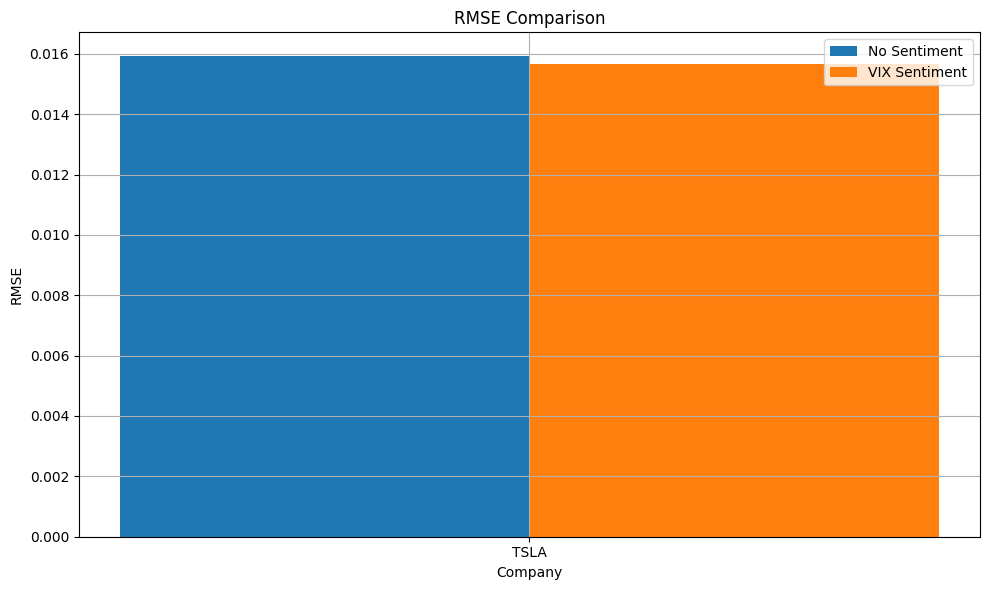

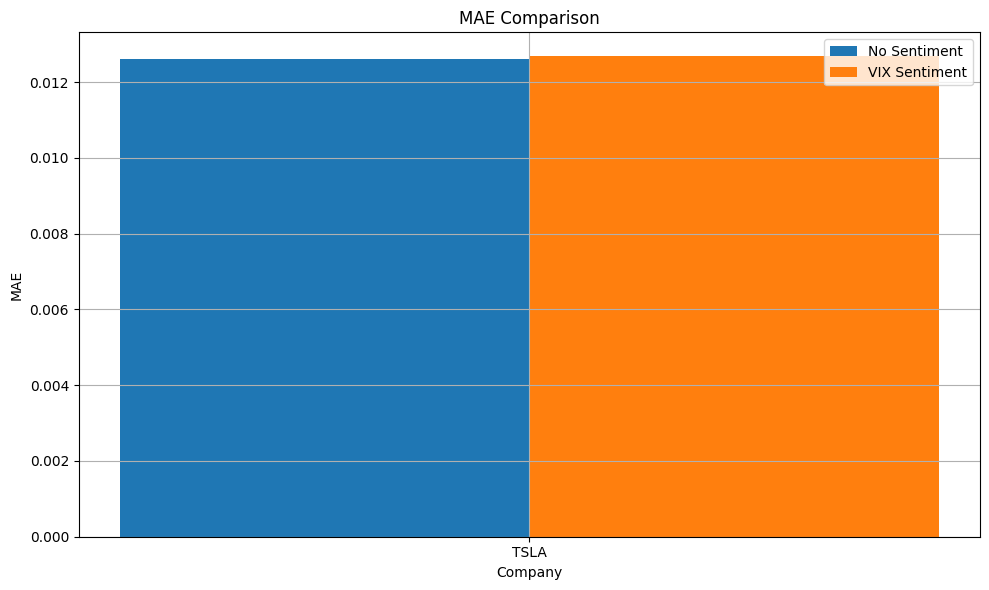

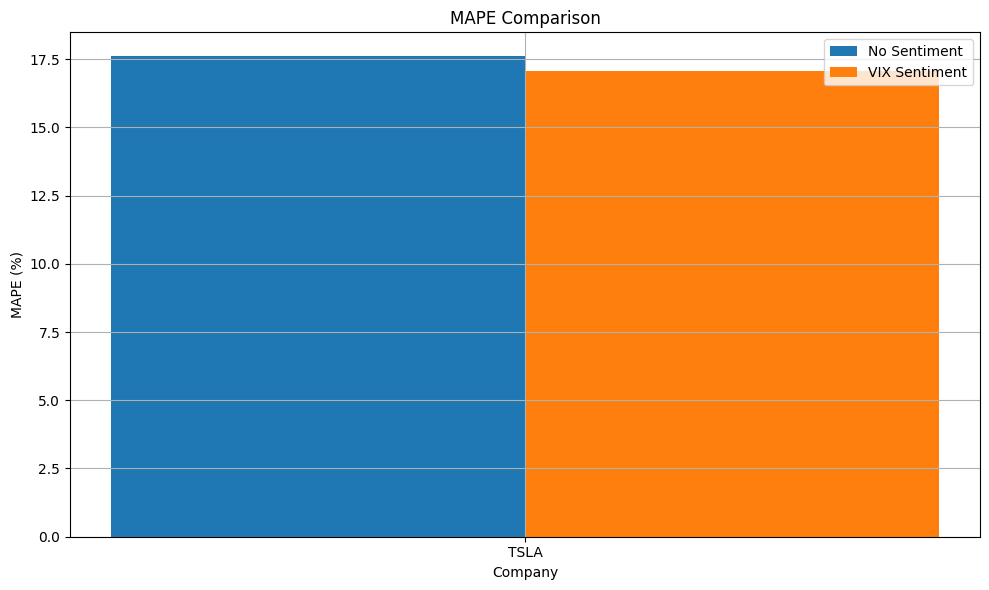

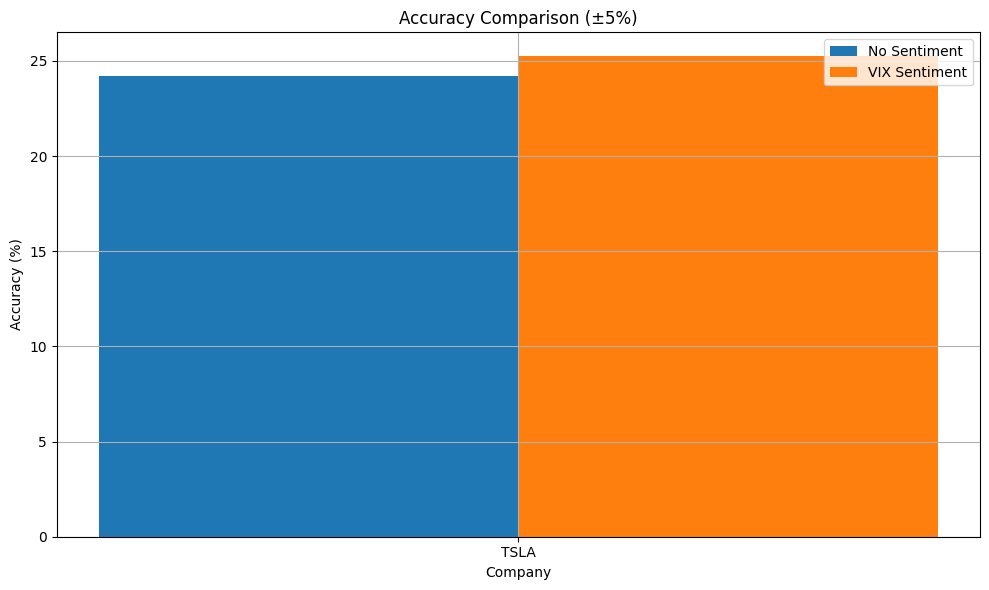


Final Results:
  Company  RMSE (no sentiment)  MAE (no sentiment)  MAPE (no sentiment)  \
0    TSLA             0.015916            0.012626            17.598433   

   Accuracy (no sentiment)  RMSE (with sentiment)  MAE (with sentiment)  \
0                24.205161               0.015675              0.012684   

   MAPE (with sentiment)  Accuracy (with sentiment)  
0              17.046696                  25.237097  


In [10]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ------------------------------
os.makedirs("results", exist_ok=True)
results_file_path = "./results/LSTM_results_vix_sentiment.csv"

# ------------------------------
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true_adj = np.where(y_true == 0, 0.001, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100

# ------------------------------
def create_dataset(dataset, seq_size, target_index):
    X, Y = [], []
    for i in range(len(dataset) - seq_size - 1):
        X.append(dataset[i:(i + seq_size)])
        Y.append(dataset[i + seq_size, target_index])
    return np.array(X), np.array(Y)

# ------------------------------
def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=500, test_window=100, threshold=0.05):
    total_samples = len(X)
    metrics_list = []

    for start in range(0, total_samples - train_window - test_window + 1, test_window):
        X_train = X[start: start + train_window]
        Y_train = Y[start: start + train_window]
        X_test  = X[start + train_window: start + train_window + test_window]
        Y_test  = Y[start + train_window: start + train_window + test_window]

        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')

        def scheduler(epoch, lr): return lr * 0.99
        callback = LearningRateScheduler(scheduler)

        model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=epochs, batch_size=batch_size, callbacks=[callback], verbose=0)

        predictions = model.predict(X_test)
        rmse = calculate_rmse(Y_test, predictions)
        mae = calculate_mae(Y_test, predictions)
        mape = calculate_mape(Y_test, predictions)
        relative_errors = np.abs((Y_test - predictions) / np.where(Y_test == 0, 0.001, Y_test))
        accuracy = np.mean(relative_errors < threshold) * 100

        metrics_list.append((rmse, mae, mape, accuracy))

    return metrics_list

# ------------------------------
results = {
    'Company': [],
    'RMSE (no sentiment)': [], 'MAE (no sentiment)': [], 'MAPE (no sentiment)': [], 'Accuracy (no sentiment)': [],
    'RMSE (with sentiment)': [], 'MAE (with sentiment)': [], 'MAPE (with sentiment)': [], 'Accuracy (with sentiment)': []
}

stock_dict = {"Tesla": "TSLA"}
start_date = "2000-01-01"
end_date = "2025-03-01"
seq_size = 10
target_index = 3

# ------------------------------
# Load VIX
vix_df = yf.download("^VIX", start=start_date, end=end_date, progress=False)[['Close']]
vix_df.rename(columns={'Close': 'VIX'}, inplace=True)
vix_df.ffill(inplace=True)

# ------------------------------
for company_name, ticker in stock_dict.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    df.reset_index(inplace=True)
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].ffill()

    # No Sentiment
    df_no = df.copy()
    cols_no = df_no.columns[1:]
    data_no = df_no[cols_no].values.astype(float)
    scaled_no = MinMaxScaler().fit_transform(data_no)
    X_no, Y_no = create_dataset(scaled_no, seq_size, target_index)
    metrics_no = rolling_window_evaluation(X_no, Y_no, seq_size, cols_no)
    rmse_no = np.mean([m[0] for m in metrics_no])
    mae_no = np.mean([m[1] for m in metrics_no])
    mape_no = np.mean([m[2] for m in metrics_no])
    acc_no = np.mean([m[3] for m in metrics_no])

    # With Sentiment = VIX
    df_with = df.copy()
    df_with = df_with.merge(vix_df, on="Date", how="left")
    df_with.rename(columns={"VIX": "Sentiment"}, inplace=True)
    df_with.ffill(inplace=True)
    cols_with = df_with.columns[1:]
    data_with = df_with[cols_with].values.astype(float)
    scaled_with = MinMaxScaler().fit_transform(data_with)
    X_with, Y_with = create_dataset(scaled_with, seq_size, target_index)
    metrics_with = rolling_window_evaluation(X_with, Y_with, seq_size, cols_with)
    rmse_with = np.mean([m[0] for m in metrics_with])
    mae_with = np.mean([m[1] for m in metrics_with])
    mape_with = np.mean([m[2] for m in metrics_with])
    acc_with = np.mean([m[3] for m in metrics_with])

    print(f"{company_name}: NoSent RMSE={rmse_no:.4f}, MAE={mae_no:.4f}, MAPE={mape_no:.2f}%, Acc={acc_no:.2f}% | "
          f"VIXSent RMSE={rmse_with:.4f}, MAE={mae_with:.4f}, MAPE={mape_with:.2f}%, Acc={acc_with:.2f}%")

    results['Company'].append(ticker)
    results['RMSE (no sentiment)'].append(rmse_no)
    results['MAE (no sentiment)'].append(mae_no)
    results['MAPE (no sentiment)'].append(mape_no)
    results['Accuracy (no sentiment)'].append(acc_no)
    results['RMSE (with sentiment)'].append(rmse_with)
    results['MAE (with sentiment)'].append(mae_with)
    results['MAPE (with sentiment)'].append(mape_with)
    results['Accuracy (with sentiment)'].append(acc_with)

# ------------------------------
df_results = pd.DataFrame(results)
df_results.to_csv(results_file_path, index=False)

# ------------------------------
def plot_metric(metric_name, title, ylabel):
    plt.figure(figsize=(10, 6))
    x = df_results['Company']
    no_sent = df_results[f'{metric_name} (no sentiment)']
    with_sent = df_results[f'{metric_name} (with sentiment)']

    bar_width = 0.35
    index = range(len(x))

    plt.bar(index, no_sent, bar_width, label='No Sentiment')
    plt.bar([i + bar_width for i in index], with_sent, bar_width, label='VIX Sentiment')

    plt.xlabel('Company')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks([i + bar_width / 2 for i in index], x)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------
plot_metric("RMSE", "RMSE Comparison", "RMSE")
plot_metric("MAE", "MAE Comparison", "MAE")
plot_metric("MAPE", "MAPE Comparison", "MAPE (%)")
plot_metric("Accuracy", "Accuracy Comparison (¬±5%)", "Accuracy (%)")

print("\nFinal Results:")
print(df_results)

YF.download() has changed argument auto_adjust default to True
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 59ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 53ms/step
1/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 148ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x371f5bec0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function fo

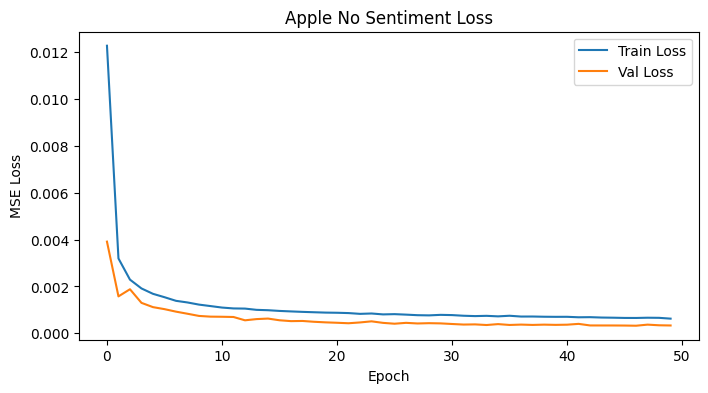

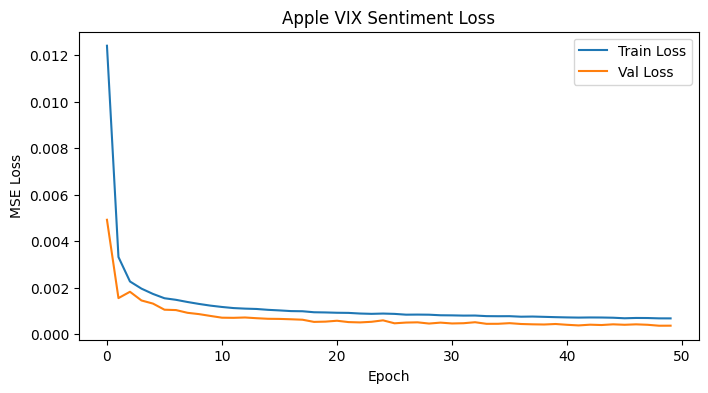

4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 60ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 59ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 60ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 62ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 60ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 63ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 62ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 61ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 63ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 63ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 58ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 62ms/step
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

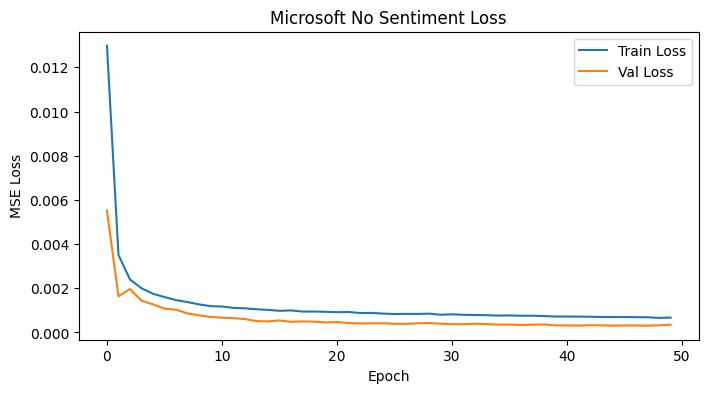

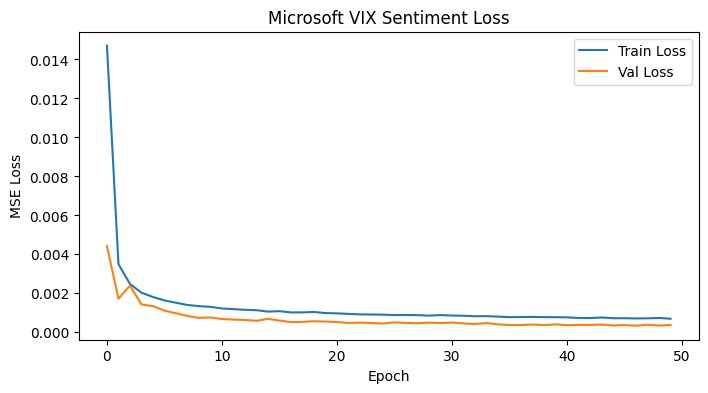


Final Results:
  Company  RMSE (no sentiment)  Accuracy (no sentiment)  \
0    AAPL             0.007141                33.996207   
1    MSFT             0.007263                33.868276   

   RMSE (with sentiment)  Accuracy (with sentiment)  
0               0.007216                  31.056379  
1               0.007331                  32.596724  


In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

os.makedirs("results", exist_ok=True)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def create_dataset(data, seq_size, target_idx):
    X, Y = [], []
    for i in range(len(data) - seq_size - 1):
        X.append(data[i:i+seq_size])
        Y.append(data[i+seq_size, target_idx])
    return np.array(X), np.array(Y)

def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=500, test_window=100, threshold=0.05):
    metrics, histories = [], []
    for start in range(0, len(X) - train_window - test_window + 1, test_window):
        X_tr, Y_tr = X[start:start+train_window], Y[start:start+train_window]
        X_te, Y_te = X[start+train_window:start+train_window+test_window], Y[start+train_window:start+train_window+test_window]

        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5))),
            Dropout(0.2),
            LSTM(32, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')

        history = model.fit(X_tr, Y_tr,
                            validation_data=(X_te, Y_te),
                            epochs=epochs, batch_size=batch_size,
                            callbacks=[LearningRateScheduler(lambda e,lr:lr*0.99)],
                            verbose=0)
        histories.append(history.history)

        preds = model.predict(X_te)
        rmse = calculate_rmse(Y_te, preds)
        accuracy = np.mean(np.abs((Y_te - preds) / np.where(Y_te==0,1e-3,Y_te)) < threshold) * 100
        metrics.append((rmse, accuracy))
    return metrics, histories

results = {'Company': [], 'RMSE (no sentiment)': [], 'Accuracy (no sentiment)': [],
           'RMSE (with sentiment)': [], 'Accuracy (with sentiment)': []}
target_idx = 3  # Close

# VIX Îç∞Ïù¥ÌÑ∞ ÎØ∏Î¶¨ Î°úÎìú
vix_df = yf.download("^VIX", start="2000-01-01", end="2025-03-01", progress=False)[['Close']]
vix_df = vix_df.rename(columns={'Close':'VIX'}).ffill()

for name, ticker in {"Apple":"AAPL","Microsoft":"MSFT"}.items():
    df = yf.download(ticker, start="2000-01-01", end="2025-03-01", progress=False)
    df.reset_index(inplace=True)
    df = df[['Date','Open','High','Low','Close','Volume']].ffill()

    # No sentiment
    data_no = df.iloc[:,1:].values.astype(float)
    scaled_no = MinMaxScaler().fit_transform(data_no)
    X_no, Y_no = create_dataset(scaled_no, seq_size=10, target_idx=target_idx)
    metrics_no, hist_no = rolling_window_evaluation(X_no, Y_no, seq_size=10, columns=df.columns[1:])
    rmse_no = np.mean([m[0] for m in metrics_no])
    acc_no = np.mean([m[1] for m in metrics_no])

    # With VIX sentiment
    df_with = df.copy().set_index('Date').join(vix_df, how='left').ffill()
    data_with = df_with.values.astype(float)
    scaled_with = MinMaxScaler().fit_transform(data_with)
    X_with, Y_with = create_dataset(scaled_with, seq_size=10, target_idx=target_idx)
    metrics_with, hist_with = rolling_window_evaluation(
        X_with, Y_with, seq_size=10, columns=df_with.columns)
    rmse_with = np.mean([m[0] for m in metrics_with])
    acc_with = np.mean([m[1] for m in metrics_with])

    print(f"{name}: NoSent RMSE={rmse_no:.4f}, Acc={acc_no:.2f}% | VIXSent RMSE={rmse_with:.4f}, Acc={acc_with:.2f}%")

    results['Company'].append(ticker)
    results['RMSE (no sentiment)'].append(rmse_no)
    results['Accuracy (no sentiment)'].append(acc_no)
    results['RMSE (with sentiment)'].append(rmse_with)
    results['Accuracy (with sentiment)'].append(acc_with)

    # ÌèâÍ∑† Loss ÏãúÍ∞ÅÌôî
    def plot_avg_loss(histories, title):
        max_ep = max(len(h['loss']) for h in histories)
        avg_train, avg_val = [], []
        for i in range(max_ep):
            train_vals = [h['loss'][i] for h in histories if len(h['loss'])>i]
            val_vals   = [h['val_loss'][i] for h in histories if len(h['val_loss'])>i]
            avg_train.append(np.mean(train_vals))
            avg_val.append(np.mean(val_vals))
        plt.figure(figsize=(8,4))
        plt.plot(avg_train, label='Train Loss')
        plt.plot(avg_val, label='Val Loss')
        plt.title(title); plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.legend(); plt.show()

    plot_avg_loss(hist_no, f"{name} No Sentiment Loss")
    plot_avg_loss(hist_with, f"{name} VIX Sentiment Loss")

df_results = pd.DataFrame(results)
df_results.to_csv("./results/LSTM_results_vix.csv", index=False)
print("\nFinal Results:")
print(df_results)

close vs OHLVC

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 978ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 873ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 775ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 703ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 781ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 756ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 781ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 692ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 638ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 833ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 713ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

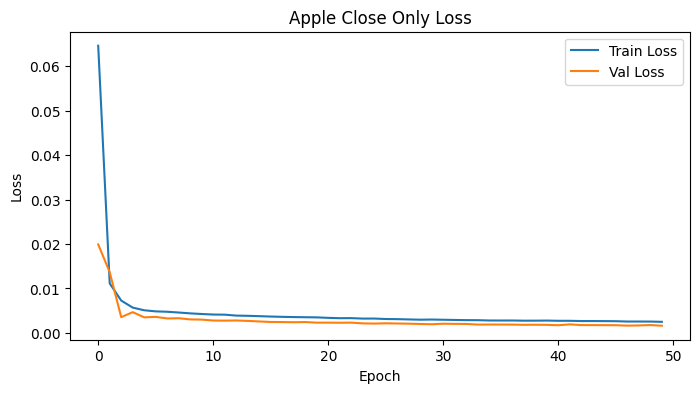

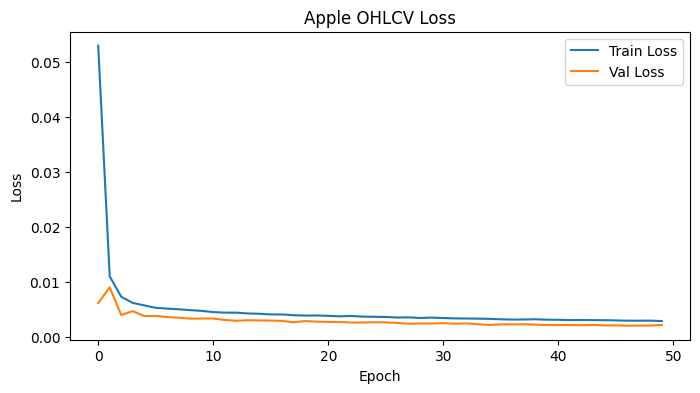

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 551ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 544ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 499ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 558ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 603ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 512ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 531ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 927ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 856ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 772ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 764ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 802ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

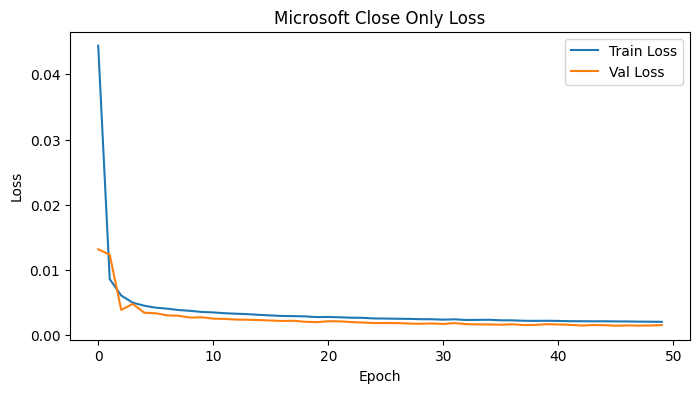

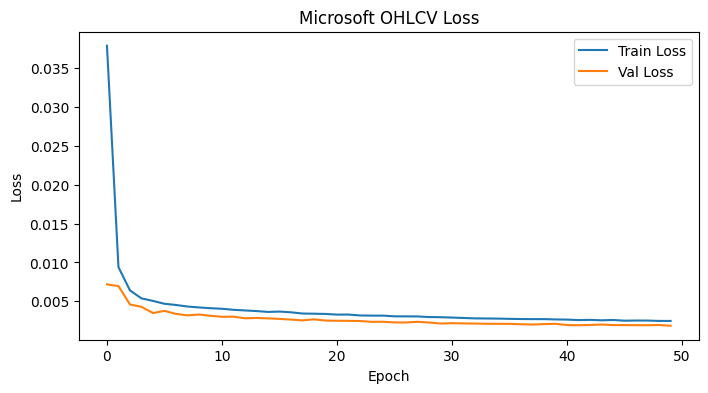


Final Results:
  Company  Close_Only_Accuracy  Close_Only_RMSE  Close_Only_MAE  \
0    AAPL            50.634921         0.036724        0.031288   
1    MSFT            44.571429         0.038355        0.032639   

   Close_Only_MAPE  OHLCV_Accuracy  OHLCV_RMSE  OHLCV_MAE  OHLCV_MAPE  
0         6.283450       48.941799    0.041482   0.035322    6.558748  
1         7.509569       45.899471    0.036680   0.030704    7.310847  


In [11]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

os.makedirs("results", exist_ok=True)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true==0, 1e-3, y_true))) * 100

def create_dataset(data, seq_size, target_idx):
    X, Y = [], []
    for i in range(len(data) - seq_size - 1):
        X.append(data[i:i+seq_size])
        Y.append(data[i+seq_size, target_idx])
    return np.array(X), np.array(Y)

def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=365, test_window=30, threshold=0.05):
    metrics, histories = [], []
    for start in range(0, len(X) - train_window - test_window + 1, test_window):
        X_tr, Y_tr = X[start:start+train_window], Y[start:start+train_window]
        X_te, Y_te = X[start+train_window:start+train_window+test_window], Y[start+train_window:start+train_window+test_window]
        
        # ÏôÑÏ†ÑÌïú Bi-LSTM Î™®Îç∏ Íµ¨ÏÑ±
        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            Bidirectional(LSTM(64, return_sequences=True, 
                                 kernel_regularizer=l2(1e-5),
                                 recurrent_dropout=0.2)),
            Dropout(0.2),
            Bidirectional(LSTM(32, return_sequences=False, 
                                 kernel_regularizer=l2(1e-5),
                                 recurrent_dropout=0.2)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1.0))
        
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=1e-6)
        history = model.fit(X_tr, Y_tr,
                            validation_data=(X_te, Y_te),
                            epochs=epochs, batch_size=batch_size,
                            callbacks=[lr_scheduler],
                            verbose=0)
        histories.append(history.history)
        
        preds = model.predict(X_te)
        rmse = calculate_rmse(Y_te, preds)
        mae = mean_absolute_error(Y_te, preds)
        mape = calculate_mape(Y_te, preds)
        accuracy = np.mean(np.abs((Y_te - preds) / np.where(Y_te==0, 1e-3, Y_te)) < threshold) * 100
        metrics.append((accuracy, rmse, mae, mape))
    return metrics, histories

# Í≤∞Í≥º Ï†ÄÏû• dict
results = {
    'Company': [],
    'Close_Only_Accuracy': [],
    'Close_Only_RMSE': [],
    'Close_Only_MAE': [],
    'Close_Only_MAPE': [],
    'OHLCV_Accuracy': [],
    'OHLCV_RMSE': [],
    'OHLCV_MAE': [],
    'OHLCV_MAPE': []
}

# ÌÉÄÍ≤ü Ïù∏Îç±Ïä§ ÏÑ§Ï†ï
target_close_index = 0  # CloseÎßå ÏÇ¨Ïö©ÌïòÎ©¥ 0Î≤àÏß∏ Ïó¥Ïù¥ Close
target_ohlcv_index = 3  # OHLCVÏóêÏÑúÎäî CloseÍ∞Ä 3Î≤àÏß∏ Ïù∏Îç±Ïä§

start_date = "2020-01-01"
end_date = "2023-12-31"

for name, ticker in {"Apple": "AAPL", "Microsoft": "MSFT"}.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    df.reset_index(inplace=True)
    df = df[['Date','Open','High','Low','Close','Volume']].ffill()
    
    # Ïã§Ìóò 1: Close Only ‚Üí Îã®Ïùº ÌîºÏ≤ò ÏûÖÎ†•
    data_close = df[['Close']].values.astype(float)
    scaled_close = MinMaxScaler().fit_transform(data_close)
    X_close, Y_close = create_dataset(scaled_close, seq_size=10, target_idx=target_close_index)
    metrics_close, hist_close = rolling_window_evaluation(X_close, Y_close, seq_size=10, columns=['Close'])
    metrics_close = np.array(metrics_close)
    acc_close, rmse_close, mae_close, mape_close = metrics_close.mean(axis=0)
    
    # Ïã§Ìóò 2: OHLCV ‚Üí 5Í∞ú ÌîºÏ≤ò ÏûÖÎ†•
    data_ohlcv = df[['Open','High','Low','Close','Volume']].values.astype(float)
    scaled_ohlcv = MinMaxScaler().fit_transform(data_ohlcv)
    X_ohlcv, Y_ohlcv = create_dataset(scaled_ohlcv, seq_size=10, target_idx=target_ohlcv_index)
    metrics_ohlcv, hist_ohlcv = rolling_window_evaluation(X_ohlcv, Y_ohlcv, seq_size=10, columns=['Open','High','Low','Close','Volume'])
    metrics_ohlcv = np.array(metrics_ohlcv)
    acc_ohlcv, rmse_ohlcv, mae_ohlcv, mape_ohlcv = metrics_ohlcv.mean(axis=0)
    
    print(f"{name}:")
    print(f"  Close Only - Accuracy: {acc_close:.2f}%, RMSE: {rmse_close:.4f}, MAE: {mae_close:.4f}, MAPE: {mape_close:.2f}%")
    print(f"  OHLCV      - Accuracy: {acc_ohlcv:.2f}%, RMSE: {rmse_ohlcv:.4f}, MAE: {mae_ohlcv:.4f}, MAPE: {mape_ohlcv:.2f}%\n")
    
    results['Company'].append(ticker)
    results['Close_Only_Accuracy'].append(acc_close)
    results['Close_Only_RMSE'].append(rmse_close)
    results['Close_Only_MAE'].append(mae_close)
    results['Close_Only_MAPE'].append(mape_close)
    results['OHLCV_Accuracy'].append(acc_ohlcv)
    results['OHLCV_RMSE'].append(rmse_ohlcv)
    results['OHLCV_MAE'].append(mae_ohlcv)
    results['OHLCV_MAPE'].append(mape_ohlcv)
    
    # ÌèâÍ∑† Loss ÏãúÍ∞ÅÌôî Ìï®Ïàò
    def plot_avg_loss(histories, title):
        max_ep = max(len(h['loss']) for h in histories)
        avg_train, avg_val = [], []
        for i in range(max_ep):
            train_vals = [h['loss'][i] for h in histories if len(h['loss']) > i]
            val_vals = [h['val_loss'][i] for h in histories if len(h['val_loss']) > i]
            avg_train.append(np.mean(train_vals))
            avg_val.append(np.mean(val_vals))
        plt.figure(figsize=(8, 4))
        plt.plot(avg_train, label='Train Loss')
        plt.plot(avg_val, label='Val Loss')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    
    plot_avg_loss(hist_close, f"{name} Close Only Loss")
    plot_avg_loss(hist_ohlcv, f"{name} OHLCV Loss")

df_results = pd.DataFrame(results)
df_results.to_csv("./results/LSTM_results_close_vs_ohlcv.csv", index=False)
print("\nFinal Results:")
print(df_results)

## OHLCV ÌûàÌä∏Îßµ , RandomForest ÌîºÏ≤òÏûÑÌè¨ÌÑ¥Ïä§, PCA 2D ÏπòÏõêÏ∂ïÏÜå


üéØ Î∂ÑÏÑù ÎåÄÏÉÅ: AAPL (2020-01-01 ~ 2023-12-31)


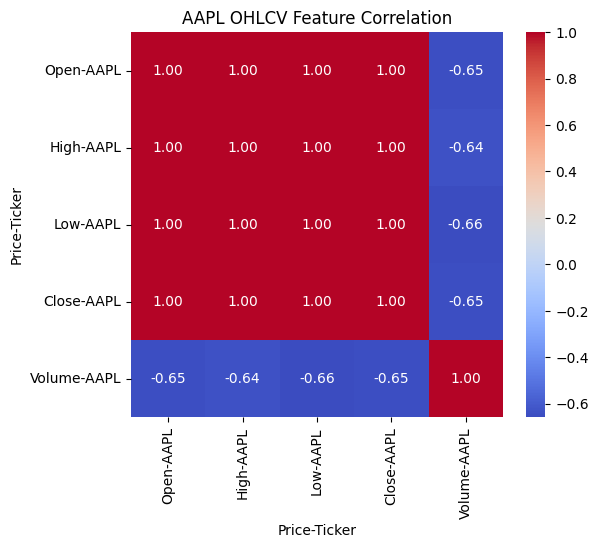

/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/1140019183.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_feat = df['Close'].shift(-1).fillna(method='ffill')  # Îã§Ïùå ÎÇ† Ï¢ÖÍ∞Ä ÏòàÏ∏°
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


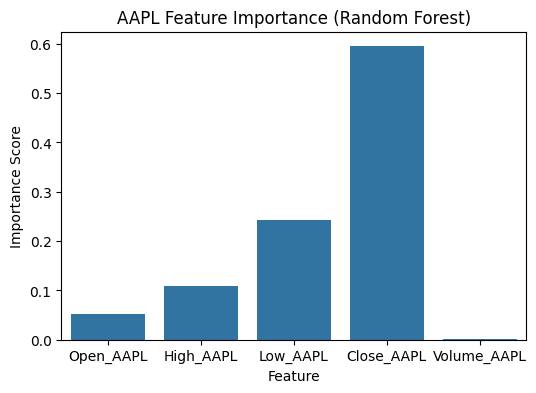

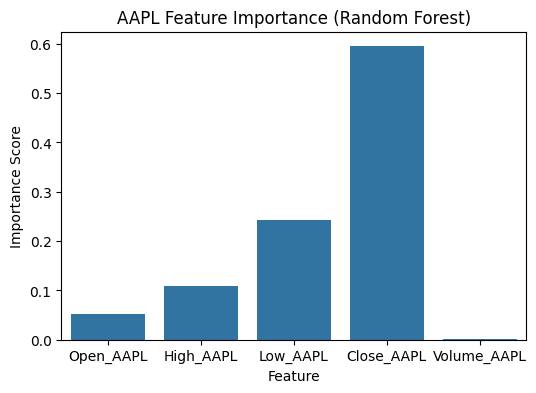


üìâ PCA Explained Variance Ratio:
  PC1: 0.8957
  PC2: 0.1037


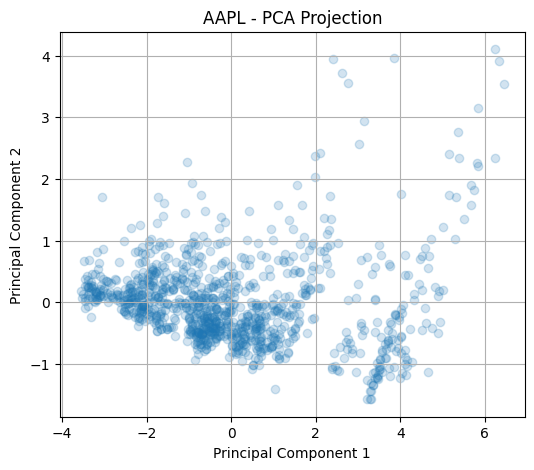

In [18]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Î∂ÑÏÑùÌï† Ï¢ÖÎ™©Í≥º Í∏∞Í∞Ñ
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2023-12-31"

# Îç∞Ïù¥ÌÑ∞ Îã§Ïö¥Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨
df = yf.download(ticker, start=start_date, end=end_date, progress=False)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].ffill()

print(f"\nüéØ Î∂ÑÏÑù ÎåÄÏÉÅ: {ticker} ({start_date} ~ {end_date})")

# üìä 1. ÏÉÅÍ¥ÄÍ≥ÑÏàò ÌûàÌä∏Îßµ
plt.figure(figsize=(6, 5))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"{ticker} OHLCV Feature Correlation")
plt.show()

# üß† 2. Feature Importance (Random Forest)
X_feat = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# üí° MultiIndexÍ∞Ä ÏûàÏùÑ Í≤ΩÏö∞ Îã®Ïùº Ïù∏Îç±Ïä§Î°ú Î≥ÄÌôò
if isinstance(X_feat.columns, pd.MultiIndex):
    X_feat.columns = ['_'.join(col).strip() for col in X_feat.columns.values]
else:
    X_feat.columns = X_feat.columns.astype(str)

y_feat = df['Close'].shift(-1).fillna(method='ffill')  # Îã§Ïùå ÎÇ† Ï¢ÖÍ∞Ä ÏòàÏ∏°

# Î™®Îç∏ ÌïôÏäµ
rf = RandomForestRegressor(random_state=42)
rf.fit(X_feat, y_feat)

# Ï§ëÏöîÎèÑ ÏãúÍ∞ÅÌôî
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_feat.columns,
    'Importance': importances
})

plt.figure(figsize=(6, 4))
sns.barplot(data=importance_df, x='Feature', y='Importance')
plt.title(f"{ticker} Feature Importance (Random Forest)")
plt.ylabel("Importance Score")
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(data=importance_df, x='Feature', y='Importance')
plt.title(f"{ticker} Feature Importance (Random Forest)")
plt.ylabel("Importance Score")
plt.show()

# üìâ 3. PCA Î∂ÑÏÑù
scaler = StandardScaler()
scaled = scaler.fit_transform(X_feat)

pca = PCA(n_components=2)
pca.fit(scaled)

print(f"\nüìâ PCA Explained Variance Ratio:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {ratio:.4f}")

# 2D PCA ÏãúÍ∞ÅÌôî (optional)
pca_data = pca.transform(scaled)
plt.figure(figsize=(6, 5))
plt.scatter(pca_data[:, 0], pca_data[:, 1], alpha=0.2)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"{ticker} - PCA Projection")
plt.grid(True)
plt.show()

Ï∞®ÏõêÏ∂ïÏÜå
	‚Ä¢	Open, High, Low, CloseÍ∞Ä Í∞ïÌïòÍ≤å Ïó∞Í¥ÄÎêú Íµ¨Ï°∞ÎùºÎäî Í±∏ ÏãúÏÇ¨Ìï©ÎãàÎã§.
	‚Ä¢	VolumeÏù¥ Îã§ÏÜå ÎèÖÎ¶ΩÏ†ÅÏù∏ Ï†ïÎ≥¥Ïùº ÏàòÎèÑ ÏûàÏäµÎãàÎã§ (Ï£ºÏÑ±Î∂Ñ Í∏∞Ïó¨ÎèÑÍ∞Ä ÎÇÆÏùÑ Í∞ÄÎä•ÏÑ±).
	‚Ä¢	Í≥†Ï∞®Ïõê ÏûÖÎ†•ÏùÑ PCA 2DÎ°ú Ï∂ïÏÜåÌïú ÌõÑ LSTM ÏûÖÎ†•Ïóê ÌôúÏö©ÌïòÎäî Í≤ÉÎèÑ Ïã§Ìóò Í∞ÄÏπòÍ∞Ä ÏûàÏäµÎãàÎã§.

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import ReduceLROnPlateau

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true==0, 1e-3, y_true))) * 100

def create_dataset(data, seq_size, target_idx):
    X, Y = [], []
    for i in range(len(data) - seq_size - 1):
        X.append(data[i:i+seq_size])
        Y.append(data[i+seq_size, target_idx])
    return np.array(X), np.array(Y)

def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=365, test_window=30, threshold=0.05):
    metrics = []
    for start in range(0, len(X) - train_window - test_window + 1, test_window):
        X_tr, Y_tr = X[start:start+train_window], Y[start:start+train_window]
        X_te, Y_te = X[start+train_window:start+train_window+test_window], Y[start+train_window:start+train_window+test_window]

        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1.0))
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=1e-6)
        model.fit(X_tr, Y_tr, validation_data=(X_te, Y_te), epochs=epochs, batch_size=batch_size,
                  callbacks=[lr_scheduler], verbose=0)
        preds = model.predict(X_te)
        rmse = calculate_rmse(Y_te, preds)
        mae = mean_absolute_error(Y_te, preds)
        mape = calculate_mape(Y_te, preds)
        accuracy = np.mean(np.abs((Y_te - preds) / np.where(Y_te==0, 1e-3, Y_te)) < threshold) * 100
        metrics.append((accuracy, rmse, mae, mape))
    return np.array(metrics).mean(axis=0)

# üì• Îç∞Ïù¥ÌÑ∞ Îã§Ïö¥Î°úÎìú
ticker = "AAPL"
df = yf.download(ticker, start="2020-01-01", end="2023-12-31", progress=False)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].ffill()
target_idx_ohlcv = 3  # Close
target_idx_ohlc = 3   # Close

seq_size = 10

# [1] OHLCV (ÏõêÎ≥∏ ÏûÖÎ†•)
scaled_ohlcv = MinMaxScaler().fit_transform(df)
X_ohlcv, Y_ohlcv = create_dataset(scaled_ohlcv, seq_size=seq_size, target_idx=target_idx_ohlcv)
res_ohlcv = rolling_window_evaluation(X_ohlcv, Y_ohlcv, seq_size, columns=['Open','High','Low','Close','Volume'])

# [2] OHLC (Volume Ï†úÍ±∞)
df_ohlc = df[['Open','High','Low','Close']]
scaled_ohlc = MinMaxScaler().fit_transform(df_ohlc)
X_ohlc, Y_ohlc = create_dataset(scaled_ohlc, seq_size=seq_size, target_idx=target_idx_ohlc)
res_ohlc = rolling_window_evaluation(X_ohlc, Y_ohlc, seq_size, columns=['Open','High','Low','Close'])

# [3] OHLCV ‚Üí PCA 2D
scaled_std_ohlcv = StandardScaler().fit_transform(df)
pca_ohlcv = PCA(n_components=2)
pca_ohlcv_2d = pca_ohlcv.fit_transform(scaled_std_ohlcv)
X_pca_ohlcv, Y_pca_ohlcv = create_dataset(pca_ohlcv_2d, seq_size=seq_size, target_idx=1)
res_pca_ohlcv = rolling_window_evaluation(X_pca_ohlcv, Y_pca_ohlcv, seq_size, columns=['PC1','PC2'])

# [4] OHLC ‚Üí PCA 2D
scaled_std_ohlc = StandardScaler().fit_transform(df_ohlc)
pca_ohlc = PCA(n_components=2)
pca_ohlc_2d = pca_ohlc.fit_transform(scaled_std_ohlc)
X_pca_ohlc, Y_pca_ohlc = create_dataset(pca_ohlc_2d, seq_size=seq_size, target_idx=1)
res_pca_ohlc = rolling_window_evaluation(X_pca_ohlc, Y_pca_ohlc, seq_size, columns=['PC1','PC2'])

# ‚úÖ Í≤∞Í≥º Ï∂úÎ†•
print(f"\nüìä Performance Comparison for {ticker}")
print(f"[1] OHLCV         ‚Üí Accuracy: {res_ohlcv[0]:.2f}%, RMSE: {res_ohlcv[1]:.4f}, MAE: {res_ohlcv[2]:.4f}, MAPE: {res_ohlcv[3]:.2f}%")
print(f"[2] OHLC          ‚Üí Accuracy: {res_ohlc[0]:.2f}%, RMSE: {res_ohlc[1]:.4f}, MAE: {res_ohlc[2]:.4f}, MAPE: {res_ohlc[3]:.2f}%")
print(f"[3] OHLCV (PCA)   ‚Üí Accuracy: {res_pca_ohlcv[0]:.2f}%, RMSE: {res_pca_ohlcv[1]:.4f}, MAE: {res_pca_ohlcv[2]:.4f}, MAPE: {res_pca_ohlcv[3]:.2f}%")
print(f"[4] OHLC (PCA)    ‚Üí Accuracy: {res_pca_ohlc[0]:.2f}%, RMSE: {res_pca_ohlc[1]:.4f}, MAE: {res_pca_ohlc[2]:.4f}, MAPE: {res_pca_ohlc[3]:.2f}%")

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 768ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 788ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 803ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 731ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 696ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 837ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 926ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 669ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 659ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 884ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 748ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 642ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Ï∞®ÏõêÏ∂ïÏÜå Ìö®Í≥º ÏóÜÎã§. VÎèÑ ÏÉÅÍ¥ÄÍ≥ÑÏàòÎ°ú ÎπÑÍµêÌïòÎ©¥ Îñ®Ïñ¥ÏßÄÏßÄÎßå, ÏÑ±Îä•Î©¥ÏóêÏÑú Î¥§ÏùÑÎïå ÏïÑÏòà ÏùòÎØ∏ ÏóÜÎã§Í≥† Î≥º Ïàò ÏóÜÎäîÍ≤É Í∞ôÎã§.

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

os.makedirs("results", exist_ok=True)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true==0, 1e-3, y_true))) * 100

def create_dataset(data, seq_size, target_idx):
    X, Y = [], []
    for i in range(len(data) - seq_size - 1):
        X.append(data[i:i+seq_size])
        Y.append(data[i+seq_size, target_idx])
    return np.array(X), np.array(Y)

def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=365, test_window=30, threshold=0.05):
    # Í∞Å rolling windowÎßàÎã§ (Ï†ïÌôïÎèÑ, RMSE, MAE, MAPE)Î•º Í≥ÑÏÇ∞
    metrics, histories = [], []
    for start in range(0, len(X) - train_window - test_window + 1, test_window):
        X_tr, Y_tr = X[start:start+train_window], Y[start:start+train_window]
        X_te, Y_te = X[start+train_window:start+train_window+test_window], Y[start+train_window:start+train_window+test_window]

        # ÏôÑÏ†ÑÌïú Bi-LSTM Î™®Îç∏: Îëê Ï∏µ Î™®Îëê Bidirectional Ï≤òÎ¶¨
        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            Bidirectional(LSTM(64, return_sequences=True, 
                                 kernel_regularizer=l2(1e-5),
                                 recurrent_dropout=0.2)),
            Dropout(0.2),
            Bidirectional(LSTM(32, return_sequences=False, 
                                 kernel_regularizer=l2(1e-5),
                                 recurrent_dropout=0.2)),
            Dropout(0.2),
            Dense(1)
        ])
        # Huber loss ÏÇ¨Ïö© (delta=1.0)
        model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1.0))

        # ÎèôÏ†Å ÌïôÏäµÎ•† Í∞êÏÜå: Í≤ÄÏ¶ù ÏÜêÏã§ Í∞úÏÑ†Ïù¥ ÏóÜÏúºÎ©¥ ÌïôÏäµÎ•† Í∞êÏÜå
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=1e-6)
        history = model.fit(X_tr, Y_tr,
                            validation_data=(X_te, Y_te),
                            epochs=epochs, batch_size=batch_size,
                            callbacks=[lr_scheduler],
                            verbose=0)
        histories.append(history.history)

        preds = model.predict(X_te)
        rmse = calculate_rmse(Y_te, preds)
        mae = mean_absolute_error(Y_te, preds)
        mape = calculate_mape(Y_te, preds)
        # Accuracy: ÏòàÏ∏°Í∞íÏù¥ Ïã§Ï†úÍ∞íÍ≥º threshold ÎÇ¥ Ï∞®Ïù¥Í∞Ä ÎÇòÎäî ÎπÑÏú®
        accuracy = np.mean(np.abs((Y_te - preds) / np.where(Y_te==0, 1e-3, Y_te)) < threshold) * 100
        
        metrics.append((accuracy, rmse, mae, mape))
    return metrics, histories

# Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† dict (Îëê Î™®Îç∏: No sentimentÏôÄ VIX sentiment)
results = {'Company': [],
           'Accuracy (no sentiment)': [], 'RMSE (no sentiment)': [], 'MAE (no sentiment)': [], 'MAPE (no sentiment)': [],
           'Accuracy (with sentiment)': [], 'RMSE (with sentiment)': [], 'MAE (with sentiment)': [], 'MAPE (with sentiment)': []}
target_idx = 3  # Ï¢ÖÍ∞Ä (Close)

# Îç∞Ïù¥ÌÑ∞ Í∏∞Í∞Ñ: 2020-01-01 ~ 2023-12-31 (Í∏∞Î≥∏ ÌÖåÏä§Ìä∏)
start_date = "2020-01-01"
end_date = "2023-12-31"

# VIX Îç∞Ïù¥ÌÑ∞ ÎØ∏Î¶¨ Î°úÎìú
vix_df = yf.download("^VIX", start=start_date, end=end_date, progress=False)[['Close']]
vix_df = vix_df.rename(columns={'Close': 'VIX'}).ffill()

for name, ticker in {"Apple": "AAPL", "Microsoft": "MSFT"}.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    df.reset_index(inplace=True)
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].ffill()

    # No sentiment Î™®Îç∏
    data_no = df.iloc[:, 1:].values.astype(float)
    scaled_no = MinMaxScaler().fit_transform(data_no)
    X_no, Y_no = create_dataset(scaled_no, seq_size=10, target_idx=target_idx)
    metrics_no, hist_no = rolling_window_evaluation(X_no, Y_no, seq_size=10, columns=df.columns[1:])
    # ÌèâÍ∑† Í≥ÑÏÇ∞: ÏàúÏÑú = (accuracy, rmse, mae, mape)
    metrics_no = np.array(metrics_no)
    acc_no, rmse_no, mae_no, mape_no = metrics_no.mean(axis=0)

    # VIX sentiment Î™®Îç∏: VIX ÌîºÏ≤òÎ•º join
    df_with = df.copy().set_index('Date').join(vix_df, how='left').ffill()
    data_with = df_with.values.astype(float)
    scaled_with = MinMaxScaler().fit_transform(data_with)
    X_with, Y_with = create_dataset(scaled_with, seq_size=10, target_idx=target_idx)
    metrics_with, hist_with = rolling_window_evaluation(X_with, Y_with, seq_size=10, columns=df_with.columns)
    metrics_with = np.array(metrics_with)
    acc_with, rmse_with, mae_with, mape_with = metrics_with.mean(axis=0)

    print(f"{name}:")
    print(f"  No Sentiment - Accuracy: {acc_no:.2f}%, RMSE: {rmse_no:.4f}, MAE: {mae_no:.4f}, MAPE: {mape_no:.2f}%")
    print(f"  VIX Sentiment - Accuracy: {acc_with:.2f}%, RMSE: {rmse_with:.4f}, MAE: {mae_with:.4f}, MAPE: {mape_with:.2f}%\n")

    results['Company'].append(ticker)
    results['Accuracy (no sentiment)'].append(acc_no)
    results['RMSE (no sentiment)'].append(rmse_no)
    results['MAE (no sentiment)'].append(mae_no)
    results['MAPE (no sentiment)'].append(mape_no)
    results['Accuracy (with sentiment)'].append(acc_with)
    results['RMSE (with sentiment)'].append(rmse_with)
    results['MAE (with sentiment)'].append(mae_with)
    results['MAPE (with sentiment)'].append(mape_with)

    # ÌèâÍ∑† Loss ÏãúÍ∞ÅÌôî
    def plot_avg_loss(histories, title):
        max_ep = max(len(h['loss']) for h in histories)
        avg_train, avg_val = [], []
        for i in range(max_ep):
            train_vals = [h['loss'][i] for h in histories if len(h['loss']) > i]
            val_vals = [h['val_loss'][i] for h in histories if len(h['val_loss']) > i]
            avg_train.append(np.mean(train_vals))
            avg_val.append(np.mean(val_vals))
        plt.figure(figsize=(8, 4))
        plt.plot(avg_train, label='Train Loss')
        plt.plot(avg_val, label='Val Loss')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    plot_avg_loss(hist_no, f"{name} No Sentiment Loss")
    plot_avg_loss(hist_with, f"{name} VIX Sentiment Loss")

df_results = pd.DataFrame(results)
df_results.to_csv("./results/LSTM_results_vix.csv", index=False)
print("\nFinal Results:")
print(df_results)

## CASE3 (OHLCV + VIX + Statistics[RSI, MACD, Bollinger B])

### ============================================
###  Î™©Ï†Å: LSTM Í∏∞Î∞ò Ï£ºÍ∞Ä ÏòàÏ∏° ÏÑ±Îä• ÎπÑÍµê Ïã§Ìóò
#### - ÏûÖÎ†• ÌîºÏ≤ò Íµ¨ÏÑ±Ïóê Îî∞Îùº Î™®Îç∏ ÏÑ±Îä•Ïù¥ Ïñ¥ÎñªÍ≤å Îã¨ÎùºÏßÄÎäîÏßÄ ÎπÑÍµê
#### - Ïã§Ìóò ÎåÄÏÉÅ:
####   [1] Base: OHLCVÎßå ÏÇ¨Ïö©
####   [2] VIX Sentiment: OHLCV + VIX (Í≥µÌè¨/ÌÉêÏöï Í∞êÏÑ±ÏßÄÌëú)
####   [3] Hybrid: OHLCV + VIX + Í∏∞Ïà†Ï†Å ÏßÄÌëú (RSI, MACD, Bollinger %B)
#### - ÏÑ±Îä• ÏßÄÌëú: Accuracy, RMSE, MAE, MAPE
#### - ÏãúÍ∞ÅÌôîÎ•º ÌÜµÌï¥ ÏÑ±Îä• Ï∞®Ïù¥Î•º ÏßÅÍ¥ÄÏ†ÅÏúºÎ°ú ÌôïÏù∏
### ============================================

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
1/1 ‚îÅ‚îÅ‚î

/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/2275891717.py:143: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


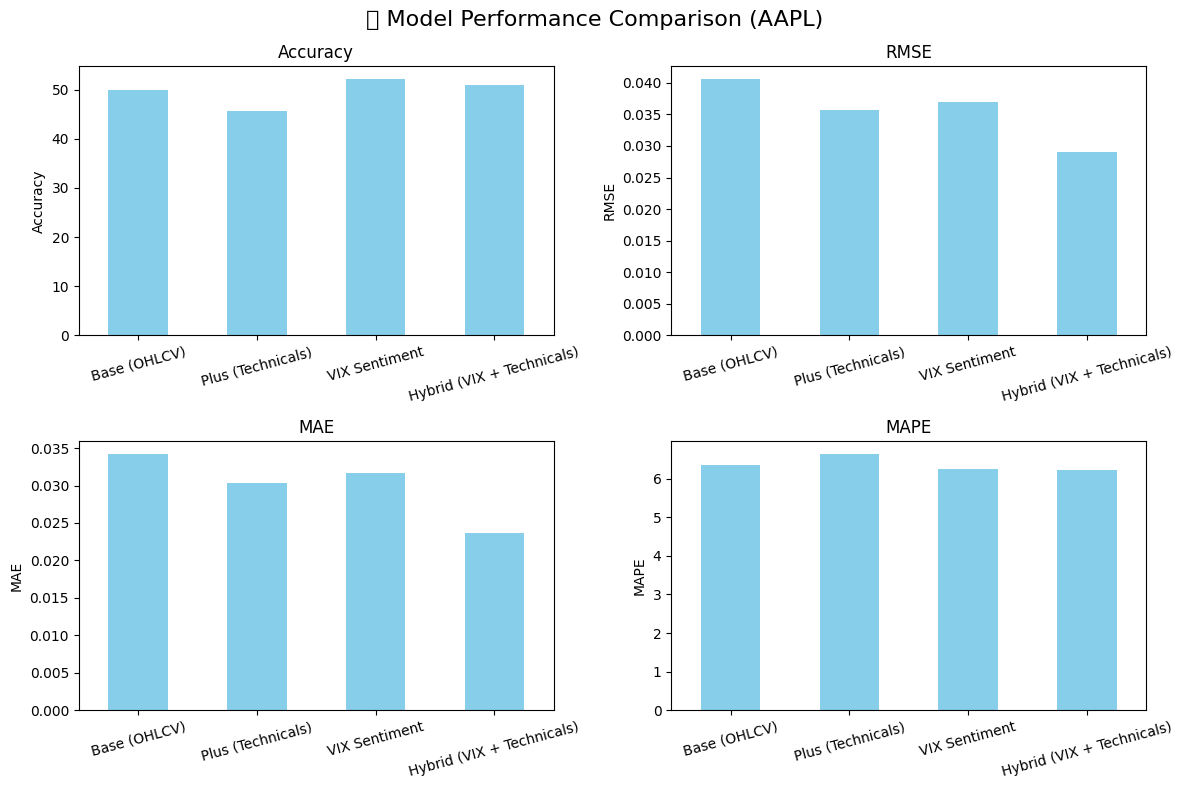

                            Accuracy      RMSE       MAE      MAPE
Base (OHLCV)               49.989418  0.040590  0.034185  6.357796
Plus (Technicals)          45.634921  0.035732  0.030380  6.634616
VIX Sentiment              52.158730  0.036993  0.031615  6.241245
Hybrid (VIX + Technicals)  51.010582  0.029023  0.023650  6.218691


In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf
import ta  # Í∏∞Ïà†Ï†Å ÏßÄÌëú ÎùºÏù¥Î∏åÎü¨Î¶¨

# =============================================================================
# Î™©Ï†Å:
# 1. AAPL Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞Î•º Yahoo FinanceÏóêÏÑú Îã§Ïö¥Î°úÎìúÌïòÍ≥†, VIX Î∞è Í∏∞Ïà†Ï†Å ÏßÄÌëú(RSI, MACD, BBP)Î•º Í≥ÑÏÇ∞
# 2. OHLCV, OHLCV+Technicals, OHLCV+VIX, OHLCV+VIX+Technicals ÎÑ§ Í∞ÄÏßÄ variantÎ•º Íµ¨ÏÑ± (df_plus Ìè¨Ìï®)
# 3. Í∞Å variantÏóê ÎåÄÌï¥ Ï†ïÍ∑úÌôî ÌõÑ, Ïó∞ÏÜç 10ÏùºÏπò Îç∞Ïù¥ÌÑ∞Î•º ÏûÖÎ†•ÏúºÎ°ú Îã§Ïùå ÎÇ†Ïùò Ï¢ÖÍ∞ÄÎ•º ÏòàÏ∏°ÌïòÎäî LSTM Î™®Îç∏ÏùÑ
#    rolling window Î∞©ÏãùÏúºÎ°ú ÌïôÏäµ Î∞è ÌèâÍ∞ÄÌïòÏó¨ ÏÑ±Îä•(Accuracy, RMSE, MAE, MAPE)ÏùÑ ÏÇ∞Ï∂ú
# 4. variantÎ≥Ñ Î™®Îç∏ ÏÑ±Îä•ÏùÑ ÏãúÍ∞ÅÌôîÌïòÏó¨ ÎπÑÍµê Î∂ÑÏÑù
# =============================================================================

# ========================== Helper Functions ============================

# RMSE Í≥ÑÏÇ∞ Ìï®Ïàò
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE Í≥ÑÏÇ∞ Ìï®Ïàò
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-3, y_true))) * 100

# ÏãúÍ≥ÑÏó¥ LSTM ÏûÖÎ†• ÌòïÏãùÏúºÎ°ú Î≥ÄÌôòÌïòÎäî Ìï®Ïàò
# ÏûÖÎ†• ÏãúÌÄÄÏä§Î•º ÎßåÎì§Í≥†, Í∞Å ÏãúÌÄÄÏä§ Ïù¥ÌõÑÏùò Ï¢ÖÍ∞ÄÎ•º ÌÉÄÍ≤üÏúºÎ°ú ÏÑ§Ï†ï
def create_dataset(data, seq_size, target_idx):
    X, Y = [], []
    for i in range(len(data) - seq_size - 1):
        X.append(data[i:i + seq_size])
        Y.append(data[i + seq_size, target_idx])
    return np.array(X), np.array(Y)

# Î°§ÎßÅ ÏúàÎèÑÏö∞ Î∞©ÏãùÏúºÎ°ú LSTM Î™®Îç∏ÏùÑ ÌïôÏäµÌïòÍ≥† ÌèâÍ∞ÄÌïòÎäî Ìï®Ïàò
# ÏùºÏ†ï Íµ¨Í∞ÑÎßåÌÅº ÌïôÏäµ ÌõÑ Îã§Ïùå Íµ¨Í∞ÑÏùÑ ÌÖåÏä§Ìä∏ÌïòÎäî Íµ¨Ï°∞
def rolling_window_evaluation(X, Y, seq_size, columns, epochs=30, batch_size=32,
                              train_window=365, test_window=30, threshold=0.05):
    metrics = []
    for start in range(0, len(X) - train_window - test_window + 1, test_window):
        # ÌïôÏäµ/ÌÖåÏä§Ìä∏ Î∂ÑÌï†
        X_tr, Y_tr = X[start:start + train_window], Y[start:start + train_window]
        X_te, Y_te = X[start + train_window:start + train_window + test_window], Y[start + train_window:start + train_window + test_window]

        # Bi-LSTM Î™®Îç∏ Íµ¨ÏÑ±
        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1.0))

        # Í≤ÄÏ¶ù ÏÜêÏã§ Í∞úÏÑ† ÏóÜÏùÑ Ïãú ÌïôÏäµÎ•† Í∞êÏÜå
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=1e-6)

        # Î™®Îç∏ ÌïôÏäµ
        model.fit(X_tr, Y_tr, validation_data=(X_te, Y_te),
                  epochs=epochs, batch_size=batch_size,
                  callbacks=[lr_scheduler], verbose=0)

        # ÏòàÏ∏° Î∞è ÌèâÍ∞Ä ÏßÄÌëú Í≥ÑÏÇ∞
        preds = model.predict(X_te)
        rmse = calculate_rmse(Y_te, preds)
        mae = mean_absolute_error(Y_te, preds)
        mape = calculate_mape(Y_te, preds)
        accuracy = np.mean(np.abs((Y_te - preds) / np.where(Y_te == 0, 1e-3, Y_te)) < threshold) * 100
        metrics.append((accuracy, rmse, mae, mape))

    return np.array(metrics).mean(axis=0)

# ============================ Data Loading ==============================

# Ïã§Ìóò ÎåÄÏÉÅ Ï£ºÏãù Î∞è ÎÇ†Ïßú Î≤îÏúÑ ÏÑ§Ï†ï
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2023-12-31"
seq_size = 10
target_idx = 3  # 'Close'Í∞Ä ÎÑ§ Î≤àÏß∏ Ïª¨Îüº

# Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞ Îã§Ïö¥Î°úÎìú Î∞è Í≤∞Ï∏°Í∞í Ï≤òÎ¶¨
df = yf.download(ticker, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']].ffill()

# VIX Îç∞Ïù¥ÌÑ∞ Îã§Ïö¥Î°úÎìú Î∞è Í≤∞Ï∏°Í∞í Ï≤òÎ¶¨
vix = yf.download("^VIX", start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'VIX'}).ffill()

# Í∏∞Ïà†Ï†Å ÏßÄÌëú Ï∂îÍ∞Ä (RSI, MACD, Bollinger %B)
close_series = df['Close'].squeeze()
df['RSI'] = ta.momentum.RSIIndicator(close=close_series, window=14).rsi()
df['MACD'] = ta.trend.MACD(close=close_series).macd_diff()
df['BBP'] = ta.volatility.BollingerBands(close=close_series).bollinger_pband()
df = df.ffill().bfill()  # NaN Ï†úÍ±∞: forward fill ÌõÑ backward fill

# ========================== Dataset Variants ============================

# Base Î™®Îç∏: OHLCVÎßå ÏÇ¨Ïö©
df_base = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# Plus Î™®Îç∏: OHLCV + Í∏∞Ïà†Ï†Å ÏßÄÌëú 3Ï¢Ö (RSI, MACD, BBP)
df_plus = df_base.join(df[['RSI', 'MACD', 'BBP']], how='left').ffill()

# VIX Î™®Îç∏: OHLCV + VIX
df_vix = df_base.join(vix, how='left').ffill()

# Hybrid Î™®Îç∏: OHLCV + VIX + Í∏∞Ïà†Ï†Å ÏßÄÌëú 3Ï¢Ö
df_hybrid = df_vix.join(df[['RSI', 'MACD', 'BBP']], how='left').ffill()

# Ïã§Ìóò ÎåÄÏÉÅ Î¶¨Ïä§Ìä∏ Î∞è ÎùºÎ≤® (4Í∞ÄÏßÄ variant)
variants = [df_base, df_plus, df_vix, df_hybrid]
labels = ['Base (OHLCV)', 'Plus (Technicals)', 'VIX Sentiment', 'Hybrid (VIX + Technicals)']

# ======================== Model Training ================================

results = []
for df_model in variants:
    data = df_model.values.astype(float)
    scaled = MinMaxScaler().fit_transform(data)  # Ï†ïÍ∑úÌôî
    X, Y = create_dataset(scaled, seq_size=seq_size, target_idx=target_idx)
    metrics = rolling_window_evaluation(X, Y, seq_size, columns=df_model.columns)
    results.append(metrics)

# ====================== Visualization ===================================

# Í≤∞Í≥º DataFrame ÏÉùÏÑ± Î∞è ÏãúÍ∞ÅÌôî
results_df = pd.DataFrame(results, columns=['Accuracy', 'RMSE', 'MAE', 'MAPE'], index=labels)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    results_df[results_df.columns[i]].plot(kind='bar', ax=ax, title=results_df.columns[i], color='skyblue')
    ax.set_ylabel(results_df.columns[i])
    ax.set_xticklabels(results_df.index, rotation=15)

plt.suptitle("üìä Model Performance Comparison (AAPL)", fontsize=16)
plt.tight_layout()
plt.show()

# Í≤∞Í≥º Ï∂úÎ†•
print(results_df)

## CASE4 (OHLCV + DailyNEWS Sentiment)

### =============================================================================
### Î™©Ï†Å:
#### 1. FinBERTÎ•º Ïù¥Ïö©Ìï¥ AAPL Îâ¥Ïä§ Ï†úÎ™©ÏóêÏÑú Í∞êÏÑ± Î∂ÑÏÑù ÏàòÌñâ Î∞è Í∞êÏÑ± Ï†êÏàò ÏÇ∞Ï∂ú
#### 2. ÎÇ†ÏßúÎ≥Ñ Îâ¥Ïä§ Í∞êÏÑ± Ï†êÏàò(ÌèâÍ∑†)Î•º Í≥ÑÏÇ∞ÌïòÍ≥†, MinMax Ï†ïÍ∑úÌôî ÏàòÌñâ
#### 3. Yahoo FinanceÏóêÏÑú OHLCV Îç∞Ïù¥ÌÑ∞Î•º Î°úÎìúÌïòÍ≥†, Í∞êÏÑ± Ï†êÏàòÏôÄ Î≥ëÌï©ÌïòÏó¨ LSTM ÏûÖÎ†•Ïö© Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±
#### 4. LSTM Î™®Îç∏ÏùÑ Íµ¨Ï∂ïÌïòÏó¨ Í∞êÏÑ± ÌîºÏ≤òÍ∞Ä ÏóÜÎäî Í≤ΩÏö∞(Í∏∞Î≥∏)ÏôÄ Í∞êÏÑ± ÌîºÏ≤òÍ∞Ä Ìè¨Ìï®Îêú Í≤ΩÏö∞Ïùò ÏÑ±Îä• ÎπÑÍµê
#### 5. Îëê Î™®Îç∏Ïùò ÏÑ±Îä•(Accuracy, RMSE, MAE, MAPE)ÏùÑ CSVÎ°ú Ï†ÄÏû•ÌïòÍ≥†, ÏãúÍ∞ÅÌôîÌïòÏó¨ ÎπÑÍµê Î∂ÑÏÑù
### =============================================================================

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Device set to use mps:0
[*********************100%***********************]  1 of 1 completed

Îâ¥Ïä§ Í∞úÏàò (ÎÇ†ÏßúÎ≥Ñ):
            date ticker  news_count
0     2020-01-01   AAPL           5
1     2020-01-02   AAPL           5
2     2020-01-03   AAPL           5
3     2020-01-04   AAPL           5
4     2020-01-05   AAPL           5
...          ...    ...         ...
1455  2023-12-27   AAPL           5
1456  2023-12-28   AAPL           5
1457  2023-12-29   AAPL           5
1458  2023-12-30   AAPL           5
1459  2023-12-31   AAPL           5

[1460 rows x 3 columns]
‚úÖ FinBERT Í∞êÏÑ± Î∂ÑÏÑù Î∞è LSTM ÏûÖÎ†•Ïö© ÌîºÏ≤ò ÏÉùÏÑ± ÏôÑÎ£å


7/7 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 412ms/step
7/7 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 240ms/step
‚úÖ LSTM ÏÑ±Îä• ÎπÑÍµê ÏôÑÎ£å (with sentiment vs no sentiment)
  ticker  Accuracy_no_sentiment  RMSE_no_sentiment  MAE_no_sentiment  \
0   AAPL              30.888109           0.038143          0.032743   

   MAPE_no_sentiment  Accuracy_with_sentiment  RMSE_with_sentiment  \
0           9.669982                  31.4386             0.033787   

   MAE_with_sentiment  MAPE_with_sentiment  
0            0.028873             9.615633  


/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/2990505897.py:219: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/2990505897.py:219: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/2990505897.py:219: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/2990505897.py:219: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/2990505897.py:219: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fd/p8gl394x5wjgxs6cdb2744br0

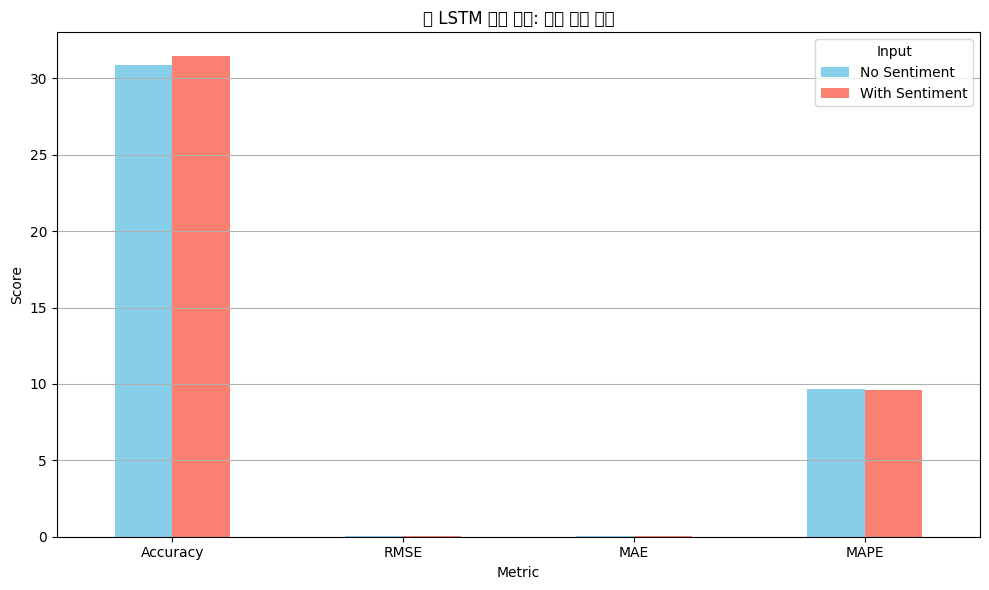

üìä Í∞êÏÑ± Î∂ÑÏÑù Ïú†Î¨¥ ÏÑ±Îä• ÎπÑÍµê ÏãúÍ∞ÅÌôî ÏôÑÎ£å


In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import yfinance as yf

# ====================== Step 1. FinBERT Î°úÎìú ===========================
model_name = "ProsusAI/finbert"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# ====================== Step 2. Îâ¥Ïä§ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ========================
df_news = pd.read_csv("/Users/parkchangyu/Githubrepo/Finance-insights/results/news/AAPL_news.csv")

# ÎÇ†Ïßú Ìè¨Îß∑ ÌÜµÏùº & ticker Ïª¨Îüº Ï∂îÍ∞Ä
df_news['date'] = pd.to_datetime(df_news['Date']).dt.date
df_news['ticker'] = 'AAPL'  # Îã®Ïùº Ï¢ÖÎ™© Ï≤òÎ¶¨

# Í∞êÏÑ± Ï†êÏàò Î≥ÄÌôò Ìï®Ïàò (1~100 Ïä§ÏºÄÏùº)
def sentiment_score(label):
    return {
        'positive': 90,
        'neutral': 50,
        'negative': 10
    }.get(label.lower(), 50)

# Í∞êÏÑ± Î∂ÑÏÑù Ïã§Ìñâ (Title Í∏∞Ï§Ä)
def analyze_sentiments(df):
    # Í∞Å Îâ¥Ïä§ Ï†úÎ™©Ïóê ÎåÄÌï¥ FinBERT Í∞êÏÑ± Î∂ÑÏÑù Ïã§Ìñâ
    df['sentiment'] = df['Title'].apply(lambda x: finbert(x)[0]['label'])
    df['score'] = df['sentiment'].apply(sentiment_score)
    return df

df_scored = analyze_sentiments(df_news)
df_scored.to_csv("news_scored.csv", index=False)

# ÎÇ†ÏßúÎ≥Ñ Îâ¥Ïä§ Í∏∞ÏÇ¨ Í∞úÏàò ÌôïÏù∏ (ÎîîÎ≤ÑÍπÖÏö©)
news_count = df_scored.groupby(['date', 'ticker']).size().reset_index(name='news_count')
print("Îâ¥Ïä§ Í∞úÏàò (ÎÇ†ÏßúÎ≥Ñ):")
print(news_count)

# =================== Step 3. Í∞êÏÑ± Ï†êÏàò ÏßëÍ≥Ñ =============================
# ÎÇ†ÏßúÎ≥Ñ Îâ¥Ïä§ Í∏∞ÏÇ¨ 5Í±¥Ïùò Í∞êÏÑ± Ï†êÏàò ÌèâÍ∑† Í≥ÑÏÇ∞
mean_sent = df_scored.groupby(['date', 'ticker'])['score'].mean().reset_index().rename(columns={'score': 'sentiment_mean'})
scaler_mean = MinMaxScaler()
mean_sent['sentiment_mean_scaled'] = scaler_mean.fit_transform(mean_sent[['sentiment_mean']])

# =================== Step 4. OHLCV Î≥ëÌï© (Yahoo FinanceÏóêÏÑú Î°úÎìú) ===============================
ticker_list = df_scored['ticker'].unique()
df_ohlcv_all = []
for ticker in ticker_list:
    # ÏãúÏûë/Ï¢ÖÎ£å ÎÇ†ÏßúÎäî Îâ¥Ïä§ Îç∞Ïù¥ÌÑ∞Ïùò ÏµúÏÜå, ÏµúÎåÄ ÎÇ†Ïßú ÏÇ¨Ïö©
    df_ticker = yf.download(ticker, start=str(df_scored['date'].min()), end=str(df_scored['date'].max()))
    df_ticker = df_ticker[['Open', 'High', 'Low', 'Close', 'Volume']].reset_index()
    # Ïª¨Îüº Ïù¥Î¶ÑÏùÑ ÏÜåÎ¨∏ÏûêÎ°ú Î≥ÄÌôò (tupleÏù¥Î©¥ Ï≤´ ÏöîÏÜå ÏÇ¨Ïö©)
    df_ticker.columns = [col[0].lower() if isinstance(col, tuple) else col.lower() for col in df_ticker.columns]
    df_ticker['ticker'] = ticker
    df_ohlcv_all.append(df_ticker)
df_ohlcv = pd.concat(df_ohlcv_all)
df_ohlcv['date'] = pd.to_datetime(df_ohlcv['date']).dt.date

# Î≥ëÌï© Ï†Ñ Ïù∏Îç±Ïä§ Ï¥àÍ∏∞Ìôî
mean_sent = mean_sent.reset_index(drop=True)
df_ohlcv = df_ohlcv.reset_index(drop=True)

# Í∞êÏÑ± Ï†êÏàò Î≥ëÌï© (df_mean: OHLCV + Í∞êÏÑ±)
df_mean = pd.merge(df_ohlcv, mean_sent[['date', 'ticker', 'sentiment_mean_scaled']], on=['date', 'ticker'], how='left')
df_mean['sentiment_mean_scaled'] = df_mean['sentiment_mean_scaled'].fillna(0)

# Ï†ÄÏû• (Ï∞∏Í≥†Ïö©)
df_ohlcv.to_csv("lstm_input_without_sentiment.csv", index=False)
df_mean.to_csv("lstm_input_with_sentiment.csv", index=False)

print("‚úÖ FinBERT Í∞êÏÑ± Î∂ÑÏÑù Î∞è LSTM ÏûÖÎ†•Ïö© ÌîºÏ≤ò ÏÉùÏÑ± ÏôÑÎ£å")


# ============================================
# LSTM Î™®Îç∏ ÌïôÏäµ Î∞è ÏÑ±Îä• ÎπÑÍµê (Í∞êÏÑ± Ïú†Î¨¥)
# ============================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ÌèâÍ∞Ä Ìï®Ïàò
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-3, y_true))) * 100

# Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ± Ìï®Ïàò
def create_dataset(data, seq_size, target_idx):
    X, Y = [], []
    for i in range(len(data) - seq_size - 1):
        X.append(data[i:i+seq_size])
        Y.append(data[i+seq_size, target_idx])
    return np.array(X), np.array(Y)

# 1) Baseline: OHLCVÎßå ÏÇ¨Ïö© (Í∞êÏÑ± ÏóÜÏùå)
def train_lstm_model_without_sentiment(df_input, label='no_sentiment'):
    df_input = df_input.sort_values(by=['ticker', 'date'])
    results = []
    for ticker in df_input['ticker'].unique():
        df_t = df_input[df_input['ticker'] == ticker].copy()
        df_t = df_t[['open', 'high', 'low', 'close', 'volume']]
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(df_t)
        X, Y = create_dataset(scaled, seq_size=10, target_idx=3)
        
        model = Sequential([
            Input(shape=(10, X.shape[2])),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1.0))
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=1e-6)
        
        split = int(len(X) * 0.8)
        X_train, Y_train = X[:split], Y[:split]
        X_test, Y_test = X[split:], Y[split:]
        model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=30, batch_size=32, callbacks=[lr_scheduler], verbose=0)
        preds = model.predict(X_test)
        
        rmse = calculate_rmse(Y_test, preds)
        mae = mean_absolute_error(Y_test, preds)
        mape = calculate_mape(Y_test, preds)
        accuracy = np.mean(np.abs((Y_test - preds)/np.where(Y_test==0,1e-3,Y_test)) < 0.05) * 100
        results.append((ticker, accuracy, rmse, mae, mape))
        
    return pd.DataFrame(results, columns=['ticker', f'Accuracy_{label}', f'RMSE_{label}', f'MAE_{label}', f'MAPE_{label}'])

# 2) With Sentiment: OHLCV + Í∞êÏÑ± Ï†êÏàò (Ïó¨Í∏∞ÏÑúÎäî sentiment_mean_scaled ÏÇ¨Ïö©)
def train_lstm_model_with_sentiment(df_input, sentiment_column, label='with_sentiment'):
    df_input = df_input.sort_values(by=['ticker', 'date'])
    results = []
    for ticker in df_input['ticker'].unique():
        df_t = df_input[df_input['ticker'] == ticker].copy()
        df_t = df_t[['open', 'high', 'low', 'close', 'volume', sentiment_column]]
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(df_t)
        X, Y = create_dataset(scaled, seq_size=10, target_idx=3)
        
        model = Sequential([
            Input(shape=(10, X.shape[2])),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1.0))
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=1e-6)
        
        split = int(len(X) * 0.8)
        X_train, Y_train = X[:split], Y[:split]
        X_test, Y_test = X[split:], Y[split:]
        model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=30, batch_size=32, callbacks=[lr_scheduler], verbose=0)
        preds = model.predict(X_test)
        
        rmse = calculate_rmse(Y_test, preds)
        mae = mean_absolute_error(Y_test, preds)
        mape = calculate_mape(Y_test, preds)
        accuracy = np.mean(np.abs((Y_test - preds)/np.where(Y_test==0,1e-3,Y_test)) < 0.05) * 100
        results.append((ticker, accuracy, rmse, mae, mape))
        
    return pd.DataFrame(results, columns=['ticker', f'Accuracy_{label}', f'RMSE_{label}', f'MAE_{label}', f'MAPE_{label}'])

# Baseline Í≤∞Í≥º (Í∞êÏÑ± ÏóÜÏùå)
df_baseline_result = train_lstm_model_without_sentiment(df_ohlcv, label='no_sentiment')
# Í∞êÏÑ± Ìè¨Ìï® Í≤∞Í≥º (Í∞êÏÑ± ÏûàÏùå)
df_sentiment_result = train_lstm_model_with_sentiment(df_mean, sentiment_column='sentiment_mean_scaled', label='with_sentiment')

# Í≤∞Í≥º ÎπÑÍµê
df_compare = pd.merge(df_baseline_result, df_sentiment_result, on='ticker')
df_compare.to_csv("sentiment_vs_baseline_comparison_result.csv", index=False)
print("‚úÖ LSTM ÏÑ±Îä• ÎπÑÍµê ÏôÑÎ£å (with sentiment vs no sentiment)")
print(df_compare)

# =============================================
# Í∞êÏÑ± Ïú†Î¨¥ LSTM ÏÑ±Îä• ÎπÑÍµê ÏãúÍ∞ÅÌôî
import matplotlib.pyplot as plt

df_compare = pd.read_csv("sentiment_vs_baseline_comparison_result.csv")
mean_metrics = df_compare[[
    'Accuracy_no_sentiment', 'RMSE_no_sentiment', 'MAE_no_sentiment', 'MAPE_no_sentiment',
    'Accuracy_with_sentiment', 'RMSE_with_sentiment', 'MAE_with_sentiment', 'MAPE_with_sentiment'
]].mean().to_frame(name='score')

plot_df = pd.DataFrame({
    'Metric': ['Accuracy', 'RMSE', 'MAE', 'MAPE'],
    'No Sentiment': [
        mean_metrics.loc['Accuracy_no_sentiment', 'score'],
        mean_metrics.loc['RMSE_no_sentiment', 'score'],
        mean_metrics.loc['MAE_no_sentiment', 'score'],
        mean_metrics.loc['MAPE_no_sentiment', 'score']
    ],
    'With Sentiment': [
        mean_metrics.loc['Accuracy_with_sentiment', 'score'],
        mean_metrics.loc['RMSE_with_sentiment', 'score'],
        mean_metrics.loc['MAE_with_sentiment', 'score'],
        mean_metrics.loc['MAPE_with_sentiment', 'score']
    ]
})

plot_df.set_index('Metric').plot(kind='bar', figsize=(10,6), color=['skyblue','salmon'])
plt.title("üìà LSTM ÏÑ±Îä• ÎπÑÍµê: Í∞êÏÑ± Î∂ÑÏÑù Ïú†Î¨¥")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='Input')
plt.tight_layout()
plt.show()

print("üìä Í∞êÏÑ± Î∂ÑÏÑù Ïú†Î¨¥ ÏÑ±Îä• ÎπÑÍµê ÏãúÍ∞ÅÌôî ÏôÑÎ£å")

## CASE5 (OHLCV + DailyNEWS Sentiment + VIX + Statistics[RSI,MACD,Bollinger B])

Device set to use mps:0
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
1/1 ‚îÅ‚îÅ‚î

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


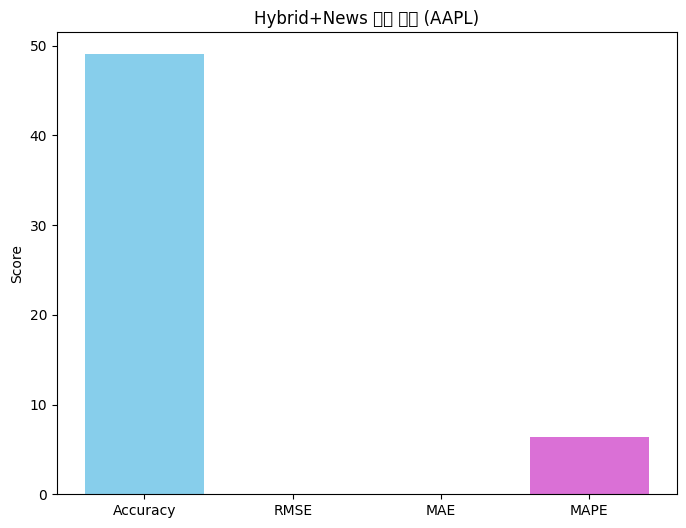

In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf
import ta  # Í∏∞Ïà†Ï†Å ÏßÄÌëú ÎùºÏù¥Î∏åÎü¨Î¶¨
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

# =============================================================================
# Î™©Ï†Å:
# 1. AAPL Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞Î•º Yahoo FinanceÏóêÏÑú Îã§Ïö¥Î°úÎìúÌïòÍ≥†, VIX Î∞è Í∏∞Ïà†Ï†Å ÏßÄÌëú(RSI, MACD, BBP)Î•º Í≥ÑÏÇ∞
# 2. Hybrid+News Î™®Îç∏ Íµ¨ÏÑ±: OHLCV + VIX + Í∏∞Ïà†Ï†Å ÏßÄÌëúÏóê FinBERT Í∏∞Î∞ò Îâ¥Ïä§ Í∞êÏÑ± ÌîºÏ≤ò(sentiment_mean_scaled)Î•º Î≥ëÌï©
# 3. Ïù¥ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥ Ï†ïÍ∑úÌôî ÌõÑ, Ïó∞ÏÜç 10ÏùºÏπò Îç∞Ïù¥ÌÑ∞Î•º ÏûÖÎ†•ÏúºÎ°ú Îã§Ïùå ÎÇ†Ïùò Ï¢ÖÍ∞ÄÎ•º ÏòàÏ∏°ÌïòÎäî LSTM Î™®Îç∏ÏùÑ
#    rolling window Î∞©ÏãùÏúºÎ°ú ÌïôÏäµ Î∞è ÌèâÍ∞ÄÌïòÏó¨ ÏÑ±Îä•(Accuracy, RMSE, MAE, MAPE)ÏùÑ ÏÇ∞Ï∂ú
# 4. Hybrid+News Î™®Îç∏Ïùò ÏÑ±Îä•ÏùÑ Ï∂úÎ†• Î∞è ÏãúÍ∞ÅÌôî
# =============================================================================

# ========================== Helper Functions ============================
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-3, y_true))) * 100

def create_dataset(data, seq_size, target_idx):
    X, Y = [], []
    for i in range(len(data) - seq_size - 1):
        X.append(data[i:i + seq_size])
        Y.append(data[i + seq_size, target_idx])
    return np.array(X), np.array(Y)

def rolling_window_evaluation(X, Y, seq_size, columns, epochs=30, batch_size=32,
                              train_window=365, test_window=30, threshold=0.05):
    metrics = []
    for start in range(0, len(X) - train_window - test_window + 1, test_window):
        X_tr, Y_tr = X[start:start + train_window], Y[start:start + train_window]
        X_te, Y_te = X[start + train_window:start + train_window + test_window], Y[start + train_window:start + train_window + test_window]
        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1.0))
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=1e-6)
        model.fit(X_tr, Y_tr, validation_data=(X_te, Y_te),
                  epochs=epochs, batch_size=batch_size,
                  callbacks=[lr_scheduler], verbose=0)
        preds = model.predict(X_te)
        rmse = calculate_rmse(Y_te, preds)
        mae = mean_absolute_error(Y_te, preds)
        mape = calculate_mape(Y_te, preds)
        accuracy = np.mean(np.abs((Y_te - preds) / np.where(Y_te == 0, 1e-3, Y_te)) < threshold) * 100
        metrics.append((accuracy, rmse, mae, mape))
    return np.array(metrics).mean(axis=0)

# ============================ News Sentiment Processing ==============================
model_name = "ProsusAI/finbert"
tokenizer = BertTokenizer.from_pretrained(model_name)
model_finbert = BertForSequenceClassification.from_pretrained(model_name)
finbert = pipeline("sentiment-analysis", model=model_finbert, tokenizer=tokenizer)

df_news = pd.read_csv("/Users/parkchangyu/Githubrepo/Finance-insights/results/news/AAPL_news.csv")
df_news['date'] = pd.to_datetime(df_news['Date']).dt.date
df_news['ticker'] = 'AAPL'  # Îã®Ïùº Ï¢ÖÎ™© Ï≤òÎ¶¨

def sentiment_score(label):
    return {'positive': 90, 'neutral': 50, 'negative': 10}.get(label.lower(), 50)

def analyze_sentiments(df):
    df['sentiment'] = df['Title'].apply(lambda x: finbert(x)[0]['label'])
    df['score'] = df['sentiment'].apply(sentiment_score)
    return df

df_scored = analyze_sentiments(df_news)
df_scored.to_csv("news_scored.csv", index=False)
mean_sent = df_scored.groupby(['date', 'ticker'])['score'].mean().reset_index().rename(columns={'score': 'sentiment_mean'})
scaler_mean = MinMaxScaler()
mean_sent['sentiment_mean_scaled'] = scaler_mean.fit_transform(mean_sent[['sentiment_mean']])
mean_sent['date'] = pd.to_datetime(mean_sent['date'])  # dtype ÌÜµÏùº

# ============================ Data Loading & Preprocessing ==============================
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2023-12-31"
seq_size = 10
target_idx = 3  # 'Close' Ïª¨Îüº

df = yf.download(ticker, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']].ffill()
vix = yf.download("^VIX", start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'VIX'}).ffill()

close_series = df['Close'].squeeze()
df['RSI'] = ta.momentum.RSIIndicator(close=close_series, window=14).rsi()
df['MACD'] = ta.trend.MACD(close=close_series).macd_diff()
df['BBP'] = ta.volatility.BollingerBands(close=close_series).bollinger_pband()
df = df.ffill().bfill()

# ========================== Dataset Variant: Hybrid+News ============================
# Hybrid Î™®Îç∏: OHLCV + VIX + Í∏∞Ïà†Ï†Å ÏßÄÌëú (RSI, MACD, BBP)
df_base = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
df_vix = df_base.join(vix, how='left').ffill()
df_hybrid = df_vix.join(df[['RSI', 'MACD', 'BBP']], how='left').ffill()

# Hybrid+News: Hybrid Î™®Îç∏Ïóê Îâ¥Ïä§ Í∞êÏÑ± ÌîºÏ≤ò Ï∂îÍ∞Ä
df_hybrid = df_hybrid.reset_index()   # Ïù∏Îç±Ïä§Î•º Î¶¨ÏÖãÌïòÏó¨ 'Date' Ïª¨Îüº ÏÉùÏÑ±
# ÌèâÌÉÑÌôî: MultiIndex Ïª¨ÎüºÏù¥ ÏûàÎã§Î©¥ Îã®Ïùº Î†àÎ≤®Î°ú Î≥ÄÌôò
if isinstance(df_hybrid.columns, pd.MultiIndex):
    df_hybrid.columns = df_hybrid.columns.get_level_values(0)
df_hybrid.rename(columns={'Date': 'date'}, inplace=True)
df_hybrid['date'] = pd.to_datetime(df_hybrid['date'])
df_hybrid['ticker'] = ticker  # ticker Ïª¨Îüº Ï∂îÍ∞Ä

# merge ÏãúÎèÑ: ÏñëÏ™ΩÏùò 'date' Ïª¨Îüº dtypeÏù¥ datetime64[ns]ÏûÑÏùÑ ÌôïÏù∏
df_hybrid_news = pd.merge(df_hybrid, mean_sent[['date', 'ticker', 'sentiment_mean_scaled']],
                          on=['date', 'ticker'], how='left')
df_hybrid_news['sentiment_mean_scaled'] = df_hybrid_news['sentiment_mean_scaled'].fillna(0)

# ======================== Model Training ================================
# Î™®Îç∏ ÏûÖÎ†•ÏúºÎ°ú ÏÇ¨Ïö©Ìï† Ïà´ÏûêÌòï Îç∞Ïù¥ÌÑ∞Îßå ÏÇ¨Ïö© ('date'ÏôÄ 'ticker' Ïª¨Îüº Ï†úÍ±∞)
data = df_hybrid_news.drop(columns=['date', 'ticker']).values.astype(float)
scaled = MinMaxScaler().fit_transform(data)
X, Y = create_dataset(scaled, seq_size=seq_size, target_idx=target_idx)
metrics = rolling_window_evaluation(X, Y, seq_size, columns=df_hybrid_news.drop(columns=['date', 'ticker']).columns)

# ====================== Visualization & Result ==========================
print("Hybrid+News Î™®Îç∏ ÏÑ±Îä• (Accuracy, RMSE, MAE, MAPE):")
print(metrics)

plt.figure(figsize=(8, 6))
plt.bar(['Accuracy', 'RMSE', 'MAE', 'MAPE'], metrics, color=['skyblue', 'salmon', 'lightgreen', 'orchid'])
plt.title("Hybrid+News Î™®Îç∏ ÏÑ±Îä• (AAPL)")
plt.ylabel("Score")
plt.show()